<center>
<img src="../../img/stack_overflow_survey.png" />
    
## [mlcourse.ai](mlcourse.ai) – Open Machine Learning Course 
### <center> Author: Kseniia Terekhova, ODS Slack Kseniia
    
## <center> Individual data analysis project
### <center> Predicting developer career satisfaction using StackOverflow survey

**Research plan**

[Part 1. Feature and data explanation](#part1) <br>
[Part 2. Primary data analysis](#EDA) <br>
[Part 3. Primary visual data analysis](#part3) <br>
[Part 4. Insights and found dependencies](#part4) <br>
[Part 5. Metrics selection](#part5) <br>
[Part 6. Model selection](#part6) <br>
[Part 7. Data preprocessing](#part7) <br>
[Part 8. Cross-validation and adjustment of model hyperparameters](#part8) <br>
[Part 9. Creation of new features and description of this process](#part9) <br>
[Part 10. Plotting training and validation curves](#part10) <br>
[Part 11. Prediction for test or hold-out samples](#part11)<br>
[Part 12. Conclusions](#part12)<br>

### Part 1. Feature and data explanation <a id='part1'></a>

#### 1.1 Dataset and task explanation

<p>This project uses the dataset with results of Stack Overflow 2018 Developer Survey. The data is publicly available through <a href="https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey/home" target=__blank>Kaggle Datasets</a>.</p>
<p>The Dataset description on Kaggle states:</p>
<blockquote cite="https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey/home">Each year, we at Stack Overflow ask the developer community about everything from their favorite technologies to their job preferences. This year marks the eighth year we’ve published our Annual Developer Survey results—with the largest number of respondents yet. Over 100,000 developers took the 30-minute survey in January 2018. <br><br>
    This year, we covered a few new topics ranging from artificial intelligence to ethics in coding. We also found that underrepresented groups in tech responded to our survey at even lower rates than we would expect from their participation in the workforce. Want to dive into the results yourself and see what you can learn about salaries or machine learning or diversity in tech? We look forward to seeing what you find!</blockquote>
<p>Indeed, there are numerous aspects of developers' lifes that can be learned from such kind of data. For this concrete project the task of <b>predicting developer career satisfaction</b> has been selected. So, the target value for this research is contained in <b>CareerSatisfaction</b> column. There is also <b>JobSatisfaction</b> feature, that could be possibly more useful for an HR or hiring manager, but for a technical specialist the question of overall career satisfaction of his/her peers seems to be more interesting.</p>
<p>The dataset consists of two files:<ul>
<li><b>survey_results_public.csv</b> with the main survey results, one respondent per row and one column per question;</li>
<li><b>survey_results_schema.csv</b> with each column name from the main results along with the question text corresponding to that column;</li></ul></p>
<p>The survey results file has columns for each one of the 128 questions, some of those are in the form "AssesBenefits4" or "AIDangerous". Detailed question content should be looked in the schema file, so the data  observation is a little bit harder process than just listing columns with short comments.</p>

#### 1.2 Survey content

That can be difficult to undestand the nature of this or that feature without seeng a corresponding question along with available answers. Thus, it looks like a good idea to go through the columns of survey results and for each of them extract the question text from the survey schema and answers used in the survey. This list will be long and tedious, so if you don't want even to scroll through it, you can jump directly to [Features conversion](#features_conversion) or [Exploratory data analysis](#EDA).

Loading the files, first of all.

In [1]:
import pandas as pd
import numpy as np

In [2]:
survey_schema = pd.read_csv('data/survey_results_schema.csv')
print(survey_schema.shape)
survey_schema.head()

(129, 2)


,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


Some preprocessing is needed to read survey_results_public.csv without warnings

In [3]:
survey_results_file = 'data/survey_results_public.csv'
with open(survey_results_file) as f:
    header = f.readline().strip()
    
col_dtypes = {col:np.object_ for col in header.split(',')}    

assesjob_dtypes = {"AssessJob" + str(i): np.float64 for i in range(1, 11)}
col_dtypes.update(assesjob_dtypes)

assesbenefits_dtypes = {"AssessBenefits" + str(i): np.float64 for i in range(1, 12)}
col_dtypes.update(assesbenefits_dtypes)

jopcontacts_dtypes = {"JobContactPriorities" + str(i): np.float64 for i in range(1, 6)}
col_dtypes.update(jopcontacts_dtypes)

jobemail_dtypes = {"JobEmailPriorities" + str(i): np.float64 for i in range(1, 8)}
col_dtypes.update(jobemail_dtypes)

ads_dtypes = {"AdsPriorities" + str(i): np.float64 for i in range(1, 8)}
col_dtypes.update(ads_dtypes)

col_dtypes['ConvertedSalary'] = np.float64

survey_results = pd.read_csv('data/survey_results_public.csv', index_col='Respondent', dtype=col_dtypes)

In [32]:
print(survey_results.shape)
survey_results.head()

(98855, 128)


,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,YearsCoding,...,Exercise,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy
Respondent,,,,,,,,,,,,,,,,,,,,,
1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,3-5 years,...,3 - 4 times per week,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy
3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,30 or more years,...,Daily or almost every day,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy
4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,24-26 years,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,18-20 years,...,I don't typically exercise,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy
7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,6-8 years,...,3 - 4 times per week,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy


Functions to extract and format the data

In [4]:
from IPython.core.display import HTML

def format_questions(questions, answers, hide_count=20):
    questions_formatted = "<b>[" + questions['Column'] + "]</b> " + \
        questions['QuestionText']
    answers_formatted = answers.map(lambda answs: 
        "{0} options".format(len(answs)) if len(answs) > hide_count else "</li><li>".join(answs.astype('str')))
    answers_formatted = answers_formatted.map(lambda a:
        "<ul><li>" + a + "</li></ul>" if a else "<br/><br/>")
    questions_answers = pd.concat([questions_formatted, answers_formatted], axis=1)
    questions_answers_formatted = questions_answers[0] + questions_answers[1]
    formatted = "".join(questions_answers_formatted.values)
    return formatted

In [5]:
def get_options(questions, survey):
    return questions.apply(lambda q: survey[q['Column']].dropna().unique(), axis=1)

In [6]:
def get_rank_questions(prefix, count, schema):
    questions_names = [prefix+str(i) for i in range(1, count+1)]
    questions_mask = schema['Column'].apply(lambda s: s in questions_names)
    questions = schema[questions_mask]['QuestionText']  
    
    first_question = questions.iat[0]
    last_dot = first_question.rfind('.')
    question_text = first_question[:last_dot+1]
    question_options = questions.str[last_dot+1:]
    return question_text, question_options.values

In [7]:
def get_multiselect_options(questions, survey, separator=";"):
    combinations = questions['Column'].map(lambda column: survey[column].dropna().unique())
    options = combinations.map(lambda comb: np.unique(np.concatenate([c.split(separator) for c in comb])))
    options = options.rename(1)
    return options

In [8]:
def format_rank_questions(prefix, count, question, options):
    question_formatted = "<b>[" + prefix + "1-" + str(count) + "]</b> " + question
    options_formatted = "</li><li>".join(options)
    if options_formatted:
        options_formatted = "<ol><li>" + options_formatted + "</li></ol>" 
    else:
        options_formatted += "</br>"

    question_formatted += options_formatted
    return question_formatted

#### So, the formatted survey content (column names are in square brackets)  <a id="survey_questions"></a>

In [9]:
coding_questions = survey_schema.loc[1:2, :]
coding_options = get_options(coding_questions, survey_results)
HTML(format_questions(coding_questions, coding_options))

In [10]:
current_questions = survey_schema.loc[3:7, :]
current_options = get_options(current_questions, survey_results)
HTML(format_questions(current_questions, current_options))

In [11]:
company_question = survey_schema.loc[8:8, :]
company_options = get_options(company_question, survey_results)

# DevType question is multiselect and needs different handling
dev_question = survey_schema.loc[9:9, :]
dev_options = get_multiselect_options(dev_question, survey_results)

experience_questions = survey_schema.loc[10:11, :]
experience_options = get_options(experience_questions, survey_results)

job_questions = pd.concat([company_question, dev_question, experience_questions])
job_options = pd.concat([company_options, dev_options, experience_options])

HTML(format_questions(job_questions, job_options))

In [12]:
job_questions = survey_schema.loc[12:16, :]
job_options = get_options(job_questions, survey_results)
HTML(format_questions(job_questions, job_options))

In [13]:
question_text, options = get_rank_questions('AssessJob', 10, survey_schema)
HTML(format_rank_questions('AssessJob', 10, question_text, options))

In [14]:
question_text, options = get_rank_questions('AssessBenefits', 11, survey_schema)
HTML(format_rank_questions('AssessBenefits', 11, question_text, options))

In [15]:
question_text, options = get_rank_questions('JobContactPriorities', 5, survey_schema)
HTML(format_rank_questions('JobContactPriorities', 5, question_text, options))

In [16]:
question_text, options = get_rank_questions('JobEmailPriorities', 7, survey_schema)
HTML(format_rank_questions('JobEmailPriorities', 7, question_text, options))

In [17]:
salary_questions = survey_schema.loc[50:55,:]
salary_questions_options = get_options(salary_questions, survey_results)

# Salary amount questions had arbitrary input
salary_questions_options.at[52] = np.empty(0)
salary_questions_options.at[54] = np.empty(0)

communication_tool_question = survey_schema.loc[56:56,:]
communication_tool_options = get_multiselect_options(communication_tool_question, survey_results)

productivity_question = survey_schema.loc[57:57, :]
productivity_options = get_options(productivity_question, survey_results)

earning_questions = pd.concat([salary_questions, communication_tool_question, productivity_question])
earning_options = pd.concat([salary_questions_options, communication_tool_options, productivity_options])

HTML(format_questions(earning_questions, earning_options))

In [18]:
edu_types_question = survey_schema.loc[58:58, :]
edu_types_options = get_multiselect_options(edu_types_question, survey_results)

self_taught_question = survey_schema.loc[59:59, :]
self_taught_options = get_multiselect_options(self_taught_question, survey_results)

bootcamp_questions = survey_schema.loc[60:60, :]
bootcamp_questions_options = get_options(bootcamp_questions, survey_results)

hackathon_questions = survey_schema.loc[61:61, :]
hackathon_questions_options = get_multiselect_options(hackathon_questions, survey_results)

training_questions = pd.concat([
    edu_types_question,
    self_taught_question,
    bootcamp_questions,
    hackathon_questions
])
training_options = pd.concat([
    edu_types_options,
    self_taught_options,
    bootcamp_questions_options,
    hackathon_questions_options
])

HTML(format_questions(training_questions, training_options))

In [19]:
agree_questions = survey_schema.loc[62:64, :]
agree_options = get_options(agree_questions, survey_results)
HTML(format_questions(agree_questions, agree_options))

In [20]:
technologies_questions = survey_schema.loc[65:72, :]
technologies_options = get_multiselect_options(technologies_questions, survey_results)
HTML(format_questions(technologies_questions, technologies_options))

In [21]:
env_questions = survey_schema.loc[73:78, :]
env_options = get_multiselect_options(env_questions, survey_results)
HTML(format_questions(env_questions, env_options))

In [22]:
adbloker_questions = survey_schema.loc[79:81, :]
adbloker_options = get_multiselect_options(adbloker_questions, survey_results)

ads_agree_questions = survey_schema.loc[82:84, :]
ads_agree_options = get_options(ads_agree_questions, survey_results)

ads_actions_question = survey_schema.loc[85:85, :]
ads_actions_options = get_multiselect_options(ads_actions_question, survey_results)

ads_questions = pd.concat([adbloker_questions, ads_agree_questions, ads_actions_question])
ads_options = pd.concat([adbloker_options, ads_agree_options, ads_actions_options])

HTML(format_questions(ads_questions, ads_options))

In [23]:
question_text, options = get_rank_questions('AdsPriorities', 7, survey_schema)
HTML(format_rank_questions('AdsPriorities', 7, question_text, options))

In [24]:
ai_ethic_questions = survey_schema.loc[93:100, :]
ai_ethic_options = get_options(ai_ethic_questions, survey_results)
HTML(format_questions(ai_ethic_questions, ai_ethic_options))

In [25]:
so_questions = survey_schema.loc[102:108, :]
so_options = get_options(so_questions, survey_results)
HTML(format_questions(so_questions, so_options))

In [26]:
question_text, options = get_rank_questions('HypotheticalTools', 5, survey_schema)
HTML(format_rank_questions('HypotheticalTools', 5, question_text, options))

In [27]:
health_questions = survey_schema.loc[114:117, :]
health_options = get_options(health_questions, survey_results)

multiselect_questions = survey_schema.loc[118:121, :]
multiselect_options = get_multiselect_options(multiselect_questions, survey_results)

personal_questions = pd.concat([health_questions, multiselect_questions])
personal_options = pd.concat([health_options, multiselect_options])

HTML(format_questions(personal_questions, personal_options))

In [28]:
family_questions = survey_schema.loc[122:126, :]
family_options = get_multiselect_options(family_questions, survey_results)
HTML(format_questions(family_questions, family_options))

In [29]:
survey_questions = survey_schema.loc[127:128, :]
survey_options = get_multiselect_options(survey_questions, survey_results)
HTML(format_questions(survey_questions, survey_options))

#### 1.2 Features conversion<a id='features_conversion'></a>

As it can be seen from the long list above, most data in the columns of survey results are just strings with repeating values. Since this is not a NLP task, they have to be converted into something more suitable even for performing simple feature analysis.

The target variable of this task is stored in the <b>CareerSatisfaction</b> column, and, sure, it should never be null during prediction. Beside this, it will easier to handle this target in the form of numeric grade.

In [33]:
from sklearn.preprocessing import LabelEncoder
import math

In [34]:
survey_results = survey_results[survey_results['CareerSatisfaction'].notna()]
full_df = pd.DataFrame(index=survey_results.index)

In [45]:
satisfaction_map = {
    'Extremely satisfied' : 7.0,
    'Moderately satisfied' : 6.0,
    'Slightly satisfied' : 5.0,
    'Neither satisfied nor dissatisfied' : 4.0,
    'Slightly dissatisfied' : 3.0,
    'Moderately dissatisfied' : 2.0,
    'Extremely dissatisfied' : 1.0,
}

In [35]:
full_df['CareerSatisfaction'] = survey_results['CareerSatisfaction'].map(satisfaction_map)

The mentioned earlier feature <b>JobSatisfaction</b> seems to be too similar to the target value. It is more interesting to try predicting <b>CareerSatisfaction</b> using more indirect factors, so <b>JobSatisfaction</b> is not included into the features list at this stage. Maybe we'll have to return to it later.

There are a few Yes/No question in the survey, it is reasonable to convert them to binary 1/0 int variables.

In [36]:
yes_no_map = {'Yes': 1, 'No': 0}
full_df['Hobby'] = survey_results['Hobby'].map(yes_no_map)
full_df['OpenSource'] = survey_results['OpenSource'].map(yes_no_map)
full_df['Dependents'] = survey_results['Dependents'].map(yes_no_map)
full_df['MilitaryUS'] = survey_results['MilitaryUS'].map(yes_no_map)

Answers to some other questions cannot be directly converted into numeric format, though there are finit set of options for each of them. Obvious decision is to to interpret them as categorical features. LabelEncoder from sklearn.preprocessing allows to assign them numeric labels.

In [4]:
categorize_cols = [
    'Country',
    'Student',
    'Employment',
    'FormalEducation',
    'UndergradMajor',
    'HopeFiveYears',
    'JobSearchStatus',
    'UpdateCV',
    'SalaryType',
    'Currency',
    'OperatingSystem',
    'CheckInCode',
    'AdBlocker',
    'AdBlockerDisable',
    'AIDangerous',
    'AIInteresting',
    'AIResponsible',
    'AIFuture',
    'EthicsChoice',
    'EthicsReport',
    'EthicsResponsible',
    'EthicalImplications',
    'StackOverflowVisit',
    'StackOverflowHasAccount',
    'StackOverflowParticipate',
    'StackOverflowJobs',
    'StackOverflowDevStory',
    'StackOverflowConsiderMember',
    'EducationParents',
    'SurveyTooLong',
    'SurveyEasy'
]

In [38]:
category_encoders = {}

for column in categorize_cols:
    category_encoders[column] = LabelEncoder()
    to_categorize = survey_results[column].fillna('Unknown')
    full_df[column] = category_encoders[column].fit_transform(to_categorize)
    full_df[column] = full_df[column].astype('category')

Most of the columns that were loaded with implicit dtype=np.float64 designation in the begining of the notebook are "rank" questions colums. Corresponding questions look like "Please rank the ..., where 1 is the most important and ... is the least important."<br>
They are numeric already, so just copy them to the features dataframe.

In [39]:
rank_cols = list(assesjob_dtypes.keys()) + \
    list(assesbenefits_dtypes.keys()) + \
    list(jopcontacts_dtypes.keys()) + \
    list(jobemail_dtypes.keys()) + \
    list(ads_dtypes.keys())

full_df[rank_cols] = survey_results[rank_cols]

The <b>ConvertedSalary</b> feature was initially float64 too.

In [40]:
full_df['ConvertedSalary'] = survey_results['ConvertedSalary']

The <b>Salary</b> column contains values with thousand separator. It has to be removed to convert values into float64.

In [41]:
full_df['Salary'] = survey_results['Salary'].str.replace(',', '').astype('float64')

There were questions in the survey that allowed multiselect options. Results of such questions are stored in the corresponded columns concatenated with ';' separator. There are too many combinations in such columns and there's no sense to categorize them in this form. It is much better to split them and convert kind of one-hot-encoding columns, for example. However, the initial options' texts should also be saved somewhere in the readable format for the case of further detailed analysis.

In [42]:
multiselect_columns_descriptions = {}

def create_binary_columns(multiselect_column, survey, result_df, separator=';'):
    combinations = survey[multiselect_column].dropna().unique()
    options = np.unique(np.concatenate([c.split(separator) for c in combinations]))    
    for i, option in enumerate(options):
        binary_column = multiselect_column + "_" + str(i)
        multiselect_columns_descriptions[binary_column] = option
        result_df[binary_column] = survey[multiselect_column].fillna("").map(lambda comb: int(option in comb))

In [43]:
multiselect_columns = [
    'DevType',
    'CommunicationTools',
    'EducationTypes',
    'SelfTaughtTypes',
    'HackathonReasons',
    'LanguageWorkedWith',
    'LanguageDesireNextYear',
    'DatabaseWorkedWith',
    'DatabaseDesireNextYear',
    'PlatformWorkedWith',
    'PlatformDesireNextYear',
    'FrameworkWorkedWith',
    'FrameworkDesireNextYear',
    'IDE',
    'Methodology',
    'VersionControl',
    'AdBlockerReasons',
    'AdsActions',
    'ErgonomicDevices',
    'Gender',
    'SexualOrientation',
    'RaceEthnicity'
]

for column in multiselect_columns:
    create_binary_columns(column, survey_results, full_df)

Columns like <b>CompanySize</b> with options "N to M employees" or <b>YearsCoding</b> with options 'N to M years' are, again, categorical. But they differ from categorical columns handled above because:<ol>
<li>Their options can be ordered, that can give useful computational information;</li>
<li>Their options ratio can cary useful patterns as well;</li></ol>
It seems reasonable to encode them by the labels that have numerical correspondence with the category. For example, the middle value of the specified interval. Some special categories ("More than..." e.g.) have to be encoded with special value, unfortunately.

In [44]:
def get_middle(low, top):
    return low + (top-low)/2

In [45]:
company_size_map = {
    'Fewer than 10 employees' : get_middle(0, 10),
    '10 to 19 employees' : get_middle(10, 20),
    '20 to 99 employees' : get_middle(20, 100),
    '100 to 499 employees' : get_middle(100, 500),
    '500 to 999 employees' : get_middle(500, 1000),
    '1,000 to 4,999 employees': get_middle(1000, 5000),
    '5,000 to 9,999 employees' : get_middle(5000, 10000),
    '10,000 or more employees' : get_middle(10000, 50000)
}

full_df['CompanySize'] = survey_results['CompanySize'].map(company_size_map)

<a id='years_coding'></a>

In [46]:
coding_years_map = {
    '0-2 years' : get_middle(0, 2),
    '3-5 years' : get_middle(3, 5),
    '6-8 years' : get_middle(6, 8),
    '9-11 years' : get_middle(9, 11),
    '12-14 years' : get_middle(12, 14),
    '15-17 years' : get_middle(15, 17),
    '18-20 years' : get_middle(18, 20),
    '21-23 years' : get_middle(21, 23),
    '24-26 years' : get_middle(24, 26),
    '27-29 years' : get_middle(27, 29),
    '30 or more years' : 35.0
}

full_df['YearsCoding'] = survey_results['YearsCoding'].map(coding_years_map)
full_df['YearsCodingProf'] = survey_results['YearsCodingProf'].map(coding_years_map)

In [47]:
last_new_job_map = {
    "I've never had a job" : 0.0,
    'Less than a year ago' : 0.5,
    'Between 1 and 2 years ago' : get_middle(1, 2),
    'Between 2 and 4 years ago' : get_middle(2, 4),
    'More than 4 years ago' : 8.0,
}

full_df['LastNewJob'] = survey_results['LastNewJob'].map(last_new_job_map)

In [48]:
time_productive_map = {
    'Less than a month' : 0.5,
    'One to three months' : get_middle(1, 3),
    'Three to six months' : get_middle(3, 6),
    'Six to nine months' : get_middle(6, 9),
    'Nine months to a year': get_middle(9, 12),
    'More than a year' : 18.0
}

full_df['TimeFullyProductive'] = survey_results['TimeFullyProductive'].map(time_productive_map)

In [49]:
bootcamp_time = {
    'I already had a full-time job as a developer when I began the program' : -1.0,
    'Immediately after graduating' : 0.0,
    'Less than a month' : get_middle(0, 1),
    'One to three months' : get_middle(1, 3),
    'Four to six months' : get_middle(4, 6),    
    'Six months to a year' : get_middle(6, 12),
    'Longer than a year' : get_middle(12, 24),
    'I haven’t gotten a developer job' : 12000
}

full_df['TimeAfterBootcamp'] = survey_results['TimeAfterBootcamp'].map(bootcamp_time)

In [50]:
wake_time_map = {
    "Before 5:00 AM" : 5.0,
    "Between 5:00 - 6:00 AM" : 6.0,
    "Between 6:01 - 7:00 AM" : 7.0,
    "Between 7:01 - 8:00 AM" : 8.0,
    "Between 8:01 - 9:00 AM" : 9.0,
    "Between 9:01 - 10:00 AM" : 10.0,
    "Between 10:01 - 11:00 AM" : 11.0,
    "Between 11:01 AM - 12:00 PM" : 12.0,
    "After 12:01 PM" : 13.0,
    "I work night shifts" : 0.0,
    "I do not have a set schedule" : -1
}

full_df['WakeTime'] = survey_results['WakeTime'].map(wake_time_map)

In [51]:
hours_computing_map = {
    "Less than 1 hour" : 0.5,
    "1 - 4 hours" : get_middle(2, 4),
    "5 - 8 hours" : get_middle(5, 8),
    "9 - 12 hours" : get_middle(9, 12),
    "Over 12 hours" : 14.0
}

full_df['HoursComputer'] = survey_results['HoursComputer'].map(hours_computing_map)

In [52]:
hours_outside_map = {
    "Less than 30 minutes" : 0.25,
    "30 - 59 minutes" : get_middle(0.5, 1.0),
    "1 - 2 hours" : get_middle(1, 2),
    "3 - 4 hours" : get_middle(3, 4),
    "Over 4 hours" : 6.0
}

full_df['HoursOutside'] = survey_results['HoursOutside'].map(hours_outside_map)

In [53]:
skip_meals_map = {
    "Never" : 0.0,
    "1 - 2 times per week" : get_middle(1, 2),
    "3 - 4 times per week" : get_middle(3, 4),
    "Daily or almost every day" : 6.0
}

full_df['SkipMeals'] = survey_results['SkipMeals'].map(skip_meals_map)

In [54]:
exercise_map = {
    "I don't typically exercise" : 0.0,
    "1 - 2 times per week" : get_middle(1, 2),
    "3 - 4 times per week" : get_middle(3, 4),
    "Daily or almost every day" : 6.0,
}

full_df['Exercise'] = survey_results['Exercise'].map(exercise_map)

In [55]:
age_map = {
    "Under 18 years old" : 16.0,
    "18 - 24 years old" : get_middle(18, 24),
    "25 - 34 years old" : get_middle(25, 34),
    "35 - 44 years old" : get_middle(35, 44),
    "45 - 54 years old" : get_middle(45, 54),
    "55 - 64 years old" : get_middle(55, 64),
    "65 years or older" : get_middle(65, 75)
}

full_df['Age'] = survey_results['Age'].map(age_map)

Some columns can be mapped to 'rank' numeric format as well, but only manually.

In [56]:
agree_degree_map = {
    'strongly agree' : 5.0,
    'agree' : 4.0,
    'somewhat agree' : 4.0,
    'disagree' : 3.0,
    'somewhat disagree' : 3.0,
    'neither agree nor disagree' : 2.0,
    'strongly disagree': 1.0,
}

agree_cols = [
    'AgreeDisagree1',
    'AgreeDisagree2',
    'AgreeDisagree3',
    'AdsAgreeDisagree1',
    'AdsAgreeDisagree2',
    'AdsAgreeDisagree3'
]

for column in agree_cols:
    full_df[column] = survey_results[column].str.lower().map(agree_degree_map)

In [57]:
hypothetical_tools_map = {
    'Not at all interested' : 1.0,
    'A little bit interested' : 2.0,
    'Somewhat interested' : 3.0,
    'Very interested' : 4.0,
    'Extremely interested' : 5.0
}

for i in range(1,6):
    column = "HypotheticalTools" + str(i)
    full_df[column] = survey_results[column].map(hypothetical_tools_map)

<b>NumberMonitors</b> and <b>StackOverflowJobsRecommend</b> columns can be easily converted to numeric format if apply simple string processing.

In [58]:
full_df['NumberMonitors'] = survey_results['NumberMonitors'].map(
    lambda mon: 6.0 if (not pd.isna(mon) and ("More" in mon)) else float(mon))

In [59]:
full_df['StackOverflowJobsRecommend'] = \
    survey_results['StackOverflowJobsRecommend'].map(lambda rec:
        rec if pd.isna(rec) else float(rec.strip(" (Very Likely)").strip(" (Not Likely)")) )

#### Save converted features to disk not to run that all each time

In [60]:
print(full_df.shape)
full_df.head()

(76504, 421)


,CareerSatisfaction,Hobby,OpenSource,Dependents,MilitaryUS,Country,Student,Employment,FormalEducation,UndergradMajor,...,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,NumberMonitors,StackOverflowJobsRecommend
Respondent,,,,,,,,,,,,,,,,,,,,,
1,7.0,1,0,1.0,NaN,82,0,1,1,10,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,NaN
3,4.0,1,1,1.0,NaN,167,0,0,1,3,...,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0
4,6.0,1,1,NaN,NaN,169,0,0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,0,0,0.0,0.0,169,0,0,1,6,...,2.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,8.0
7,6.0,1,0,1.0,NaN,145,3,0,8,6,...,4.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,2.0,NaN


In [61]:
full_df.to_csv('converted_features.csv')

In [6]:
import pickle

In [63]:
with open('category_encoders.pkl', 'wb') as encoders_file:
    pickle.dump(category_encoders, encoders_file, protocol=2)

In [64]:
with open('multiselect_columns_descriptions.pkl', 'wb') as descriptions_file:
    pickle.dump(multiselect_columns_descriptions, descriptions_file, protocol=2)

### Part 2. Primary data analysis <a id='EDA'></a>

In [3]:
from scipy import stats

#### 2.1 Load previously converted and saved data

In [4]:
import pickle

In [5]:
full_df = pd.read_csv('converted_features.csv', index_col='Respondent')

with open('category_encoders.pkl', 'rb') as encoders_file:
    category_encoders = pickle.load(encoders_file)
    
categorize_cols = list(category_encoders.keys())
    
with open('multiselect_columns_descriptions.pkl', 'rb') as descriptions_file:
    multiselect_columns_descriptions = pickle.load(descriptions_file)

In [6]:
print(full_df.shape)
full_df.head()

(76504, 421)


,CareerSatisfaction,Hobby,OpenSource,Dependents,MilitaryUS,Country,Student,Employment,FormalEducation,UndergradMajor,...,AdsAgreeDisagree1,AdsAgreeDisagree2,AdsAgreeDisagree3,HypotheticalTools1,HypotheticalTools2,HypotheticalTools3,HypotheticalTools4,HypotheticalTools5,NumberMonitors,StackOverflowJobsRecommend
Respondent,,,,,,,,,,,,,,,,,,,,,
1,7.0,1,0,1.0,NaN,82,0,1,1,10,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,NaN
3,4.0,1,1,1.0,NaN,167,0,0,1,3,...,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0
4,6.0,1,1,NaN,NaN,169,0,0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.0,0,0,0.0,0.0,169,0,0,1,6,...,2.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,8.0
7,6.0,1,0,1.0,NaN,145,3,0,8,6,...,4.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,2.0,NaN


#### 2.2. Missing data

This dataset contains survey results, where many questions were optional, ant it's no wonder that there are columns containing NAN values. Checking how many exactly. 

In [14]:
cols_with_nans = full_df.isna().mean().sort_values(ascending=False)
cols_with_nans = cols_with_nans[cols_with_nans > 0]
cols_with_nans

TimeAfterBootcamp             0.916540
MilitaryUS                    0.806128
StackOverflowJobsRecommend    0.536194
JobEmailPriorities2           0.419834
JobEmailPriorities7           0.419834
JobEmailPriorities6           0.419834
JobEmailPriorities1           0.419834
JobEmailPriorities5           0.419834
JobEmailPriorities4           0.419834
JobEmailPriorities3           0.419834
JobContactPriorities1         0.389078
JobContactPriorities2         0.389078
JobContactPriorities3         0.389078
JobContactPriorities4         0.389078
JobContactPriorities5         0.389078
ConvertedSalary               0.386111
Salary                        0.351433
TimeFullyProductive           0.326231
AdsPriorities6                0.282717
AdsPriorities7                0.282717
AdsPriorities1                0.282717
AdsPriorities2                0.282717
AdsPriorities3                0.282717
AdsPriorities5                0.282717
AdsPriorities4                0.282717
Dependents               

#### 2.3 Statistical characteristics of the target feature

First of all let's see proportion of respondents giving this or that grade to their career satisfaction level.

In [147]:
satisfaction_counts = full_df['CareerSatisfaction'].value_counts().rename('Count')
satisfaction_proportions = (full_df['CareerSatisfaction'].value_counts() / len(full_df)).rename('Part')
satisfaction_df = pd.concat([satisfaction_counts, satisfaction_proportions], axis=1)
satisfaction_df

,Count,Part
6.0,27926,0.365027
7.0,14316,0.187127
5.0,13484,0.176252
3.0,6587,0.086100
4.0,6316,0.082558
2.0,5262,0.068781
1.0,2613,0.034155


The most respondents gave "6" raiting, that is "Moderately satisfied". The "Extremely satisfied" is on the second place with little bit more proportion then "Slightly satisfied". In general, there are much more respondents who have choosen "Satisfied" grades than those who haven't. It allows to conclude that developer is a cool profession :)

Some statistics characteristics of the distribution:

In [148]:
print("CareerSatisfaction median: ", full_df['CareerSatisfaction'].median())
print("CareerSatisfaction mean: ", full_df['CareerSatisfaction'].mean())
print("CareerSatisfaction std: ", full_df['CareerSatisfaction'].std())

CareerSatisfaction median:  6.0
CareerSatisfaction mean:  5.141561225556834
CareerSatisfaction std:  1.6389014092370502


Yes, half of respondents ranked their carrier with two highest grades, and 1-5 ranks are distributed among the other half. 
The median is different from the mean, so it doesn't look like normal distribution.

In [149]:
satisfaction_values = full_df['CareerSatisfaction'].values.astype(np.float64)

_, p_normtest = stats.normaltest(satisfaction_values)
print("p-value in stats.normaltest: {0:.6f}".format(p_normtest))

p-value in stats.normaltest: 0.000000


Stats test confirms that is not. What if applying log transforms?

In [150]:
log1_satisfaction_values = np.log(1 + satisfaction_values)
log_inverted_satisfaction_values = np.log(8 - satisfaction_values)

_, p_log1_normtest = stats.normaltest(log1_satisfaction_values)
_, p_log_inverted_normtest = stats.normaltest(log_inverted_satisfaction_values)
print("p-value in log1 stats.normaltest: {0:.6f}".format(p_log1_normtest))
print("p-value in s inverted log stats.normaltest: {0:.6f}".format(p_log_inverted_normtest))

p-value in log1 stats.normaltest: 0.000000
p-value in s inverted log stats.normaltest: 0.000000


It look like the target variable isn't distributed neither normally, nor lognormally. May be that's due to discrete values of ranks, as normal distribution is continious one. Graphic of the distribution in the visual analysis section is needed to make further conclusions.

#### 2.4 CareerSatisfaction <-> JobSatisfaction correlation

Though it was decided not to use JobSatisfaction feature yet, it is better to verify the assumption about its high correlation with the target variable.

In [151]:
satisfaction_df = survey_results[['CareerSatisfaction', 'JobSatisfaction']]
satisfaction_df = satisfaction_df[
    satisfaction_df['CareerSatisfaction'].notna() & satisfaction_df['JobSatisfaction'].notna()]
satisfaction_df['CareerSatisfaction'] = satisfaction_df['CareerSatisfaction'].map(satisfaction_map)
satisfaction_df['JobSatisfaction'] = satisfaction_df['JobSatisfaction'].map(satisfaction_map)
satisfaction_df.corr()

,CareerSatisfaction,JobSatisfaction
CareerSatisfaction,1.000000,0.593935
JobSatisfaction,0.593935,1.000000


Indeed, it looks like high correlation result. Let's put this feature aside for the sake of more comprehensive analysis of other aspects. However, it can be returned if model will show too poor results without it.

#### 2.5 ConvertedSalary analysis

The only continious numeric varibles in the research were the <b>Salary</b> and <b>ConvertedSalary</b> features. The second is much more convenient for the analysis as it was converted to common denominator of "annual USD salaries using the exchange rate on 2018-01-18, assuming 12 working months and 50 working weeks". 

In [152]:
converted_salary = full_df['ConvertedSalary']
converted_salary.describe()

count    4.696500e+04
mean     9.675330e+04
std      2.031932e+05
min      0.000000e+00
25%      2.469600e+04
50%      5.598100e+04
75%      9.400000e+04
max      2.000000e+06
Name: ConvertedSalary, dtype: float64

Let's see average salaries by career satisfactions ranks

In [153]:
full_df.pivot_table(['ConvertedSalary'], ['CareerSatisfaction'], aggfunc='mean')

,ConvertedSalary
CareerSatisfaction,
1.0,97574.700441
2.0,81337.832422
3.0,86218.418929
4.0,76909.696446
5.0,83697.253697
6.0,104074.131315
7.0,110145.861186


Those who are paid the biggest average salaries are satisfied by the career the most, it is expectable result. But surprisingly, the lowest payment is received by those in the middle, with "Neither satisfied nor dissatisfied" rank. And the most dissatisfied respondents do not receive the least wage. 

Let's see the correlation

In [154]:
salary_correlation = full_df[['CareerSatisfaction', 'ConvertedSalary']].corr()
salary_correlation

,CareerSatisfaction,ConvertedSalary
CareerSatisfaction,1.000000,0.043178
ConvertedSalary,0.043178,1.000000


That's not so much. May be this dependency may get higher evaluation? DataFrame.corr() can use three correlation methods. As I know, the default 'pearson' is good for linear correlation, and we saw above that in this case it is not linear.

In [155]:
salary_correlation = full_df[['CareerSatisfaction', 'ConvertedSalary']].corr(method='spearman')
salary_correlation

,CareerSatisfaction,ConvertedSalary
CareerSatisfaction,1.000000,0.182913
ConvertedSalary,0.182913,1.000000


It's obviously better. So, spearman looks like more suitable correlation method to be used in further analysis. If the correlation between salary and satisfaction is not linear, the others shouldn't be this way all the more.

#### 2.6 Coding Experience, Professional Coding experience, Last Job Years and Age  

There are <b>YearsCoding</b>, <b>YearsCodingProf</b>, <b>LastNewJob</b> and <b>Age</b> columns in the dataset. Despite them being categorical in the survey, the way they were [processed](#years_coding) during features conversion allows to treat them as numerical values.

In [177]:
years_columns = ['CareerSatisfaction', 'YearsCoding', 'YearsCodingProf', 'LastNewJob', 'Age']
years_coding_corelation = full_df[years_columns].corr(method='spearman')
years_coding_corelation = years_coding_corelation['CareerSatisfaction'].sort_values(ascending=False)
years_coding_corelation

CareerSatisfaction    1.000000
YearsCodingProf       0.063052
YearsCoding           0.054862
Age                   0.018039
LastNewJob            0.015718
Name: CareerSatisfaction, dtype: float64

Not so much on the one hand, but not zero on the other.

#### 2.7 Some other numerical categorical features

In [178]:
numerical_features = ['TimeAfterBootcamp',
        'ConvertedSalary', 'CompanySize', 'TimeFullyProductive', 'NumberMonitors',
        'WakeTime', 'HoursComputer', 'HoursOutside', 'SkipMeals', 'Exercise'
]

numerical_correlations = full_df[['CareerSatisfaction'] + numerical_features].astype('float64').corr(method='spearman')
numerical_correlations = numerical_correlations['CareerSatisfaction'].sort_values(ascending=False)
numerical_correlations

CareerSatisfaction     1.000000
ConvertedSalary        0.182913
NumberMonitors         0.090212
Exercise               0.051191
CompanySize            0.022919
HoursComputer         -0.005023
WakeTime              -0.010328
TimeFullyProductive   -0.022407
HoursOutside          -0.027250
SkipMeals             -0.048306
TimeAfterBootcamp     -0.098974
Name: CareerSatisfaction, dtype: float64

#### 2.8 Technical role and experience

As it was the developer survey there are a number a questions devoted to technical role and technical experience; they seem to affect the technical career satisfaction. However, there are too many of them with too many answers options, so let select only few as representatives for the analysis. 

Dev roles question was multiselect and alowed to choose several options at once. Now all this options are splitted to  separate columns with "1" for the respondents checked it, and "0" for those who didn't. That doesn't prevent performing correlation check with the target variable, anyway. But some mapping with readable descriptions is needed.

In [180]:
dev_types = [dt for dt in multiselect_columns_descriptions.keys() if dt.startswith('DevType')]
dev_types_df = full_df[['CareerSatisfaction'] + dev_types]

dev_types = [multiselect_columns_descriptions[dv] for dv in dev_types]
dev_types_df = dev_types_df.rename(columns=multiselect_columns_descriptions)

In [181]:
dev_types_correlation = dev_types_df.corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False)
dev_types_correlation

CareerSatisfaction                               1.000000
Engineering manager                              0.049598
C-suite executive (CEO, CTO, etc.)               0.047887
DevOps specialist                                0.040737
Full-stack developer                             0.036597
Product manager                                  0.025695
Data scientist or machine learning specialist    0.018307
Back-end developer                               0.007011
Educator or academic researcher                  0.005794
Front-end developer                              0.003102
Mobile developer                                 0.002944
Marketing or sales professional                  0.001562
Embedded applications or devices developer      -0.001165
Database administrator                          -0.001362
QA or test developer                            -0.002059
System administrator                            -0.004868
Desktop or enterprise applications developer    -0.005695
Designer      

That could be also interesting what percent of respondents with this or that level of satisfaction perform this or that role. As all these columns contain "1" or "0" only, the mean() function (i.e. sum/count) will give us that proportion.

In [161]:
dev_types_percent = dev_types_df.pivot_table(dev_types, ['CareerSatisfaction'], aggfunc='mean')
dev_types_percent = dev_types_percent.transpose()
dev_types_percent

CareerSatisfaction,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Back-end developer,0.595101,0.597681,0.599059,0.583439,0.613097,0.608036,0.604638
"C-suite executive (CEO, CTO, etc.)",0.046307,0.032687,0.022013,0.025332,0.027366,0.037743,0.057628
Data or business analyst,0.099120,0.087989,0.096554,0.086922,0.085064,0.086228,0.084451
Data scientist or machine learning specialist,0.085343,0.081718,0.071504,0.079956,0.072234,0.085941,0.090668
Database administrator,0.160735,0.150703,0.157128,0.162286,0.149733,0.146208,0.159542
Designer,0.158056,0.129989,0.136329,0.161178,0.124444,0.120927,0.143057
Desktop or enterprise applications developer,0.177191,0.186241,0.192349,0.194427,0.187556,0.182124,0.183990
DevOps specialist,0.098354,0.099202,0.104904,0.082014,0.105088,0.119673,0.132788
Educator or academic researcher,0.042097,0.040289,0.036284,0.041482,0.030110,0.037957,0.041632
Embedded applications or devices developer,0.060850,0.056442,0.062092,0.059690,0.051320,0.056077,0.058187


The similar approaches for <b>LanguageWorkedWith</b> columns.

In [162]:
langs_worked = [l for l in multiselect_columns_descriptions.keys() if l.startswith('LanguageWorkedWith')]
lang_worked_df = full_df[['CareerSatisfaction'] + langs_worked]

langs_worked = [multiselect_columns_descriptions[l] for l in langs_worked]
langs_worked_df = lang_worked_df.rename(columns=multiselect_columns_descriptions)

In [163]:
langs_worked_correlation = langs_worked_df.corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False)
langs_worked_correlation

CareerSatisfaction      1.000000
Bash/Shell              0.051539
TypeScript              0.048590
JavaScript              0.040756
R                       0.038875
Ruby                    0.038824
Go                      0.032885
Java                    0.030800
CSS                     0.030782
HTML                    0.029567
C                       0.025828
Python                  0.025468
Swift                   0.024316
SQL                     0.023480
Kotlin                  0.023434
CoffeeScript            0.023151
Scala                   0.022293
Groovy                  0.021196
Objective-C             0.020837
C#                      0.017973
F#                      0.012238
Rust                    0.011805
Erlang                  0.009154
Clojure                 0.008811
Perl                    0.002779
Lua                     0.001887
Julia                   0.000279
Ocaml                  -0.000155
Haskell                -0.002360
Matlab                 -0.002900
VB.NET    

In [164]:
langs_worked_percent = langs_worked_df.pivot_table(langs_worked, ['CareerSatisfaction'], aggfunc='mean')
langs_worked_percent = langs_worked_percent.transpose()
langs_worked_percent

CareerSatisfaction,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Assembly,0.076158,0.059293,0.060422,0.072039,0.055473,0.054931,0.065172
Bash/Shell,0.303483,0.340935,0.338090,0.313331,0.347152,0.384445,0.389494
C,0.721776,0.728810,0.755579,0.733217,0.752966,0.760653,0.768092
C#,0.270953,0.286773,0.304236,0.290215,0.320009,0.317482,0.313495
C++,0.215078,0.213037,0.217246,0.257283,0.209508,0.204075,0.216192
CSS,0.551091,0.548651,0.568392,0.563648,0.579279,0.586371,0.603660
Clojure,0.016073,0.010832,0.012145,0.009816,0.009938,0.011710,0.014878
Cobol,0.011481,0.006271,0.006528,0.008075,0.006452,0.005371,0.006915
CoffeeScript,0.026024,0.026606,0.023531,0.023116,0.027366,0.034377,0.034227
Delphi/Object Pascal,0.026406,0.028126,0.024138,0.026124,0.024622,0.020017,0.020117


And <b>LanguageDesireNextYear</b> columns too.

In [165]:
lang_desired = [l for l in multiselect_columns_descriptions.keys() if l.startswith('LanguageDesireNextYear')]
lang_desired_df = full_df[['CareerSatisfaction'] + lang_desired]

In [166]:
lang_desired = [multiselect_columns_descriptions[l] for l in lang_desired]
lang_desired_df = lang_desired_df.rename(columns=multiselect_columns_descriptions)

In [167]:
langs_desired_correlation = lang_desired_df.corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False)
langs_desired_correlation

CareerSatisfaction      1.000000
Bash/Shell              0.040365
TypeScript              0.034861
HTML                    0.029015
CSS                     0.026265
JavaScript              0.024870
Go                      0.018186
SQL                     0.018184
Swift                   0.017544
C                       0.016269
Java                    0.016015
R                       0.009478
Rust                    0.009450
C#                      0.009422
Ruby                    0.009039
F#                      0.008360
Kotlin                  0.004180
Erlang                  0.003016
Groovy                  0.002753
Ocaml                   0.001271
Clojure                -0.000212
Haskell                -0.001878
CoffeeScript           -0.004414
Objective-C            -0.004642
Scala                  -0.005060
Python                 -0.006263
VB.NET                 -0.006592
Julia                  -0.006639
Delphi/Object Pascal   -0.007751
Perl                   -0.008277
VBA       

In [168]:
lang_desired_percent = lang_desired_df.pivot_table(lang_desired, ['CareerSatisfaction'], aggfunc='mean')
lang_desired_percent = lang_desired_percent.rename(columns=multiselect_columns_descriptions).transpose()
lang_desired_percent

CareerSatisfaction,1.0,2.0,3.0,4.0,5.0,6.0,7.0
Assembly,0.055492,0.048271,0.050858,0.058265,0.038935,0.037062,0.045823
Bash/Shell,0.205511,0.227100,0.225748,0.214060,0.226787,0.250985,0.266485
C,0.538844,0.557203,0.590405,0.576789,0.579798,0.585440,0.591436
C#,0.205128,0.208286,0.237286,0.231792,0.241175,0.239991,0.231629
C++,0.160352,0.170848,0.183240,0.200285,0.159893,0.153549,0.163384
CSS,0.329506,0.323071,0.335813,0.329164,0.340997,0.350605,0.365884
Clojure,0.028703,0.032117,0.037043,0.028182,0.031000,0.030867,0.032481
Cobol,0.010333,0.004561,0.006073,0.007125,0.003856,0.003080,0.004959
CoffeeScript,0.026024,0.018814,0.022924,0.025174,0.019060,0.018943,0.021584
Delphi/Object Pascal,0.015691,0.013683,0.012904,0.012666,0.010531,0.009418,0.012154


And also <b>OperatingSystem</b>.

In [169]:
os_df = full_df[['CareerSatisfaction', 'OperatingSystem']]

os_df['OperatingSystem'] = os_df['OperatingSystem'].map(
    lambda os: category_encoders['OperatingSystem'].inverse_transform(os)
)

os_dummies_df = pd.get_dummies(os_df, columns=['OperatingSystem'], prefix="OS")

In [170]:
os_correlation = os_dummies_df.corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False)
os_correlation

CareerSatisfaction    1.000000
OS_MacOS              0.077067
OS_BSD/Unix          -0.009608
OS_Linux-based       -0.010232
OS_Unknown           -0.031194
OS_Windows           -0.036228
Name: CareerSatisfaction, dtype: float64

Interesting: MacOS shows much higher correlation with career satisfaction than others OS. When looked on the OS percentage by satisfaction grades, it can be seen that 6- and 7- respondents use this OS more often than others. Is  MacOS the operating system of success?

In [171]:
satisfaction_os_percent = os_dummies_df.groupby(by='CareerSatisfaction').mean()
satisfaction_os_percent

,OS_BSD/Unix,OS_Linux-based,OS_MacOS,OS_Unknown,OS_Windows
CareerSatisfaction,,,,,
1.0,0.002679,0.204746,0.212017,0.166475,0.414083
2.0,0.002090,0.211707,0.210946,0.145572,0.429685
3.0,0.002733,0.201306,0.200698,0.129194,0.466070
4.0,0.002217,0.213110,0.166086,0.161970,0.456618
5.0,0.001335,0.202981,0.216998,0.131267,0.447419
6.0,0.001611,0.197737,0.260331,0.118134,0.422187
7.0,0.001118,0.197262,0.285904,0.122381,0.393336


The main conclusion that can be made from the lists and tables with numbers above, in my opinion, is that it's too hard to search dependencies in such data with the method of staring gaze. It's better to move to visual data analysis.

### Part 3. Primary visual data analysis<a id='part3'></a>

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import poisson
import warnings
warnings.filterwarnings('ignore')

#### 3.1 Target value distribution

Target value distribution in the graphical form

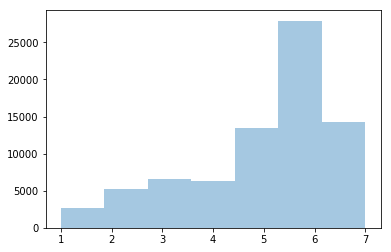

In [179]:
sns.distplot(satisfaction_values, bins=7, kde=False)

That doesn't look like normal distribution, really. May be it resembles lognormal distribution being turned around, but lognormal distribution is continious and our one is discrete. Wouldn't it be better to search for discrete distribution with similar form? The <a href="https://en.wikipedia.org/wiki/Poisson_distribution" target=__blank>Poisson distribution</a>, for instance. <br/> The histogram of Poisson distribution with the same mean and number of samples, when inverted, looks this way:

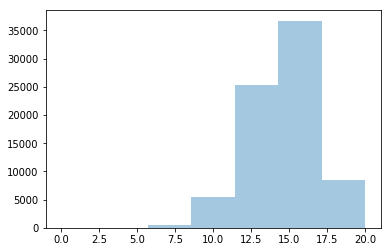

In [198]:
mu = satisfaction_values.mean()
data_poisson = poisson.rvs(mu=mu, size=len(satisfaction_values), random_state=42)
max_poisson = max(data_poisson)
ax = sns.distplot(max_poisson - data_poisson, bins=7, kde=False)

Unfortunately, I haven't found easy and relaible analytic way to check if the distribution is Poisson. Even graphical statsmodels.api qqplot doesn't easily work with Poisson. The <a href="https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.probplot.html" target=__blank>scipy.stats.probplot</a> function shows such plot:

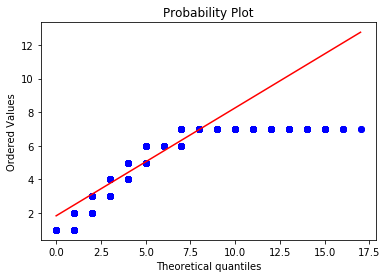

In [199]:
ax2 = plt.subplot()
res = stats.probplot(satisfaction_values, dist='poisson', sparams=(mu), plot=plt)

As I know, if the distributions are similar then the blue points should be close to 45-degree red line. For "ordered values" under 7 they are, for some extent. Apparently, the satisfaction levels has some characteristics of the Poisson distribution, but... No idea that it gives. There was a task to perform statistical analysis of the target feature, I've done it :)

#### 3.2 Boxplot for ConvertedSalary <a id="ConvertedSalaryVisual" ></a>

As <b>ConvertedSalary</b> is continuous variable and its distribution can be depicted with the boxplot.

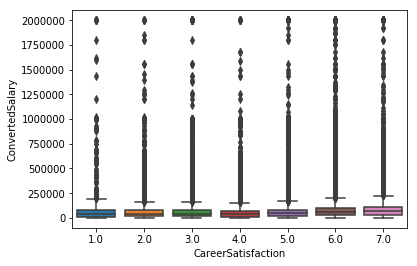

In [200]:
sns.boxplot(x='CareerSatisfaction', y='ConvertedSalary', data=full_df)

Outliers make this graph looking awful. This column required some mathematical actions to calculate converted US annual salary, may be some respondents have done it wrong. Let's see if cutting values >= 0.95 quantile would help.

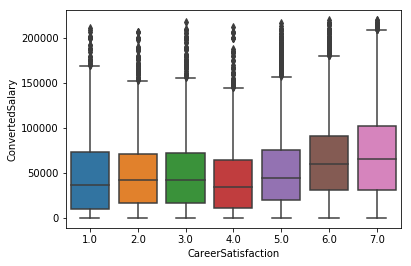

In [201]:
quantile_95 = full_df['ConvertedSalary'].quantile(0.95)
cut_salary_outliers_df = full_df[full_df['ConvertedSalary'] < quantile_95]
sns.boxplot(x='CareerSatisfaction', y='ConvertedSalary', data=cut_salary_outliers_df)

Much more useful picture. And there is indeed dependency between salary distribution and career satisfaction.

#### 3.3 Numerical category features corellations

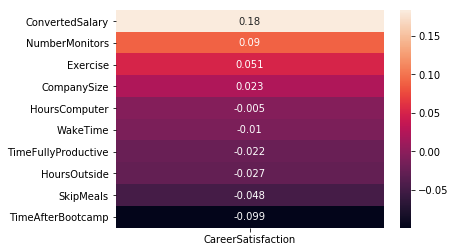

In [183]:
sns.heatmap(numerical_correlations.iloc[1:].to_frame(), annot=True)

The heatmap shows only that these features are much less correlated with the target than the <b>ConvertedSalary</b>. Maybe plots divided by satisfaction level will show something...

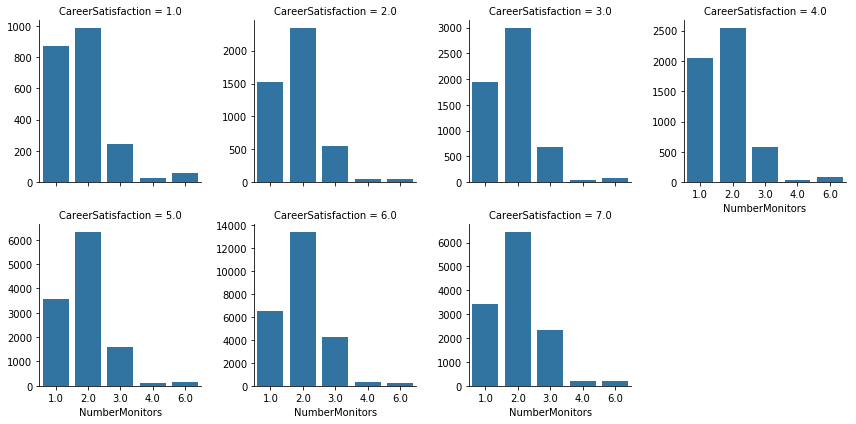

In [203]:
grid = sns.FacetGrid(full_df, col="CareerSatisfaction", col_wrap=4, sharey=False)
grid.map(sns.countplot, "NumberMonitors")

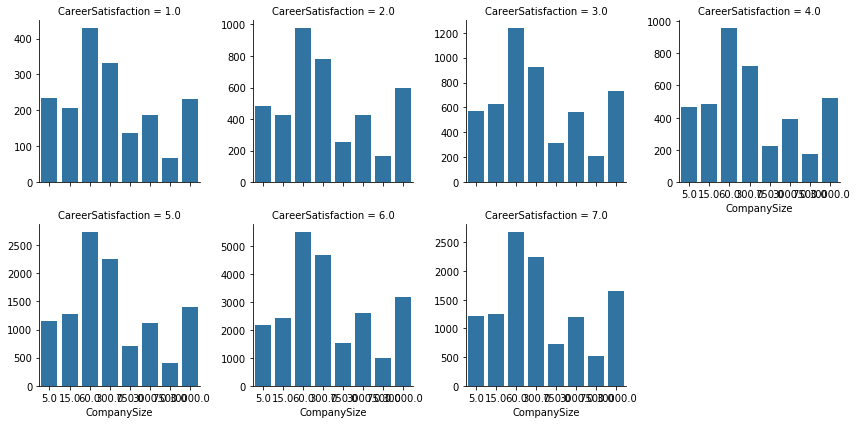

In [204]:
grid = sns.FacetGrid(full_df, col="CareerSatisfaction", col_wrap=4, sharey=False)
grid.map(sns.countplot, "CompanySize")

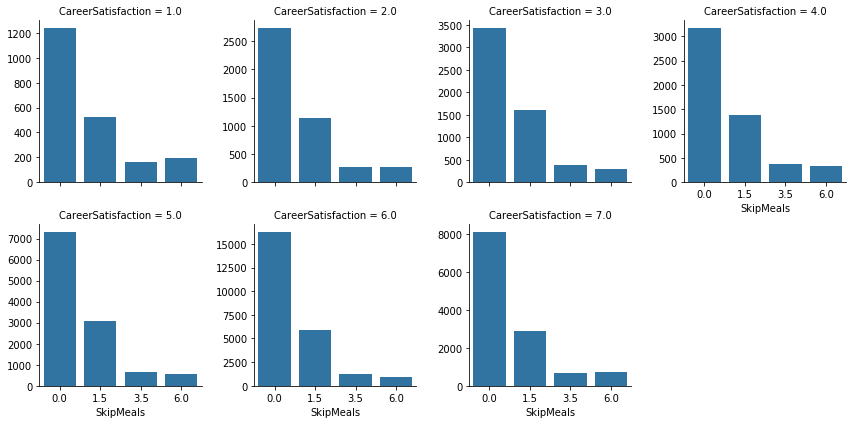

In [205]:
grid = sns.FacetGrid(full_df, col="CareerSatisfaction", col_wrap=4, sharey=False)
grid.map(sns.countplot, "SkipMeals")

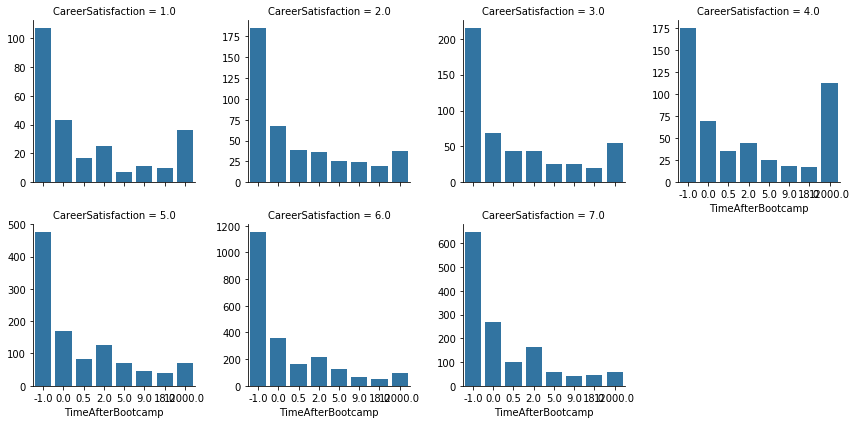

In [187]:
grid = sns.FacetGrid(full_df, col="CareerSatisfaction", col_wrap=4, sharey=False)
grid.map(sns.countplot, "TimeAfterBootcamp")

Some differences can be noticed if looking attentively, but they are not so big. And, again, the patterns are not changing in a linear manner from lower ranks to higher.

#### 3.3 Technical experience features

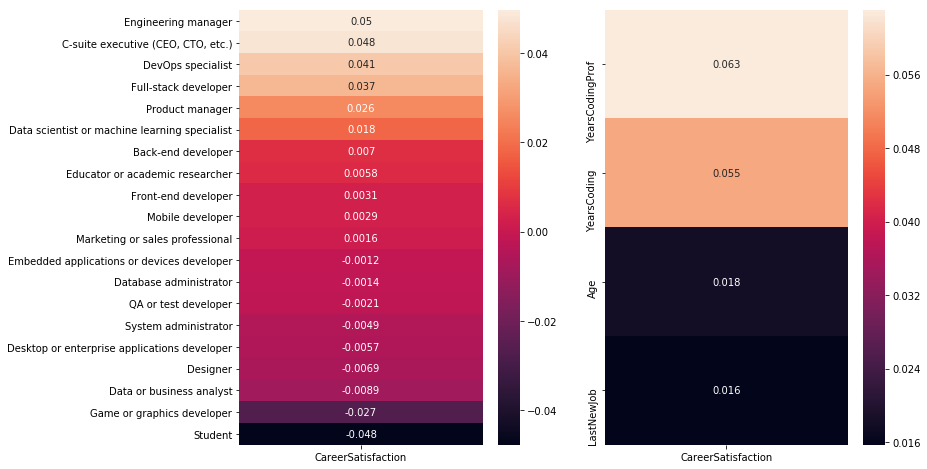

In [182]:
_, axes = plt.subplots(1, 2, figsize=(12,8), sharey=False) 
sns.heatmap(dev_types_correlation.iloc[1:].to_frame(), ax=axes[0], annot=True)
sns.heatmap(years_coding_corelation.iloc[1:].to_frame(), ax=axes[1], annot=True)

Some non-zero but not very correlated role and experience features can be seen on the heatmap.

Let's draw the percentages of dev roles by career satisfaction levels. It's <b>not the correlation heatmap</b>, so different color scheme is used.

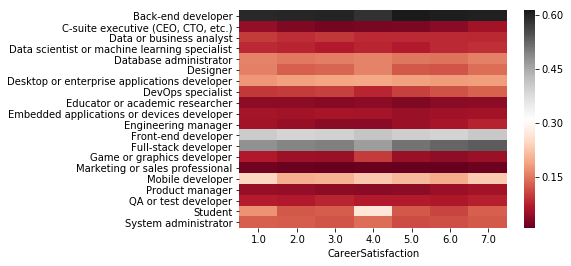

In [207]:
sns.heatmap(dev_types_percent, cmap='RdGy')

Not so many differences, but some vertical stripes can be seen, especially for the 1, 4, 6 ranks. 

Languages experience correlations

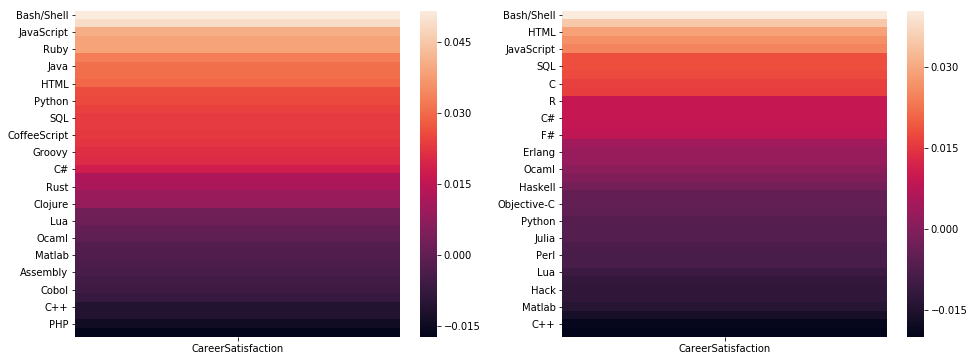

In [208]:
_, axes = plt.subplots(1, 2, figsize=(16,6), sharey=False) 
sns.heatmap(langs_worked_correlation.iloc[1:].to_frame(), ax=axes[0])
sns.heatmap(langs_desired_correlation.iloc[1:].to_frame(), ax=axes[1])

Languages experience differentiating by satisfaction levels

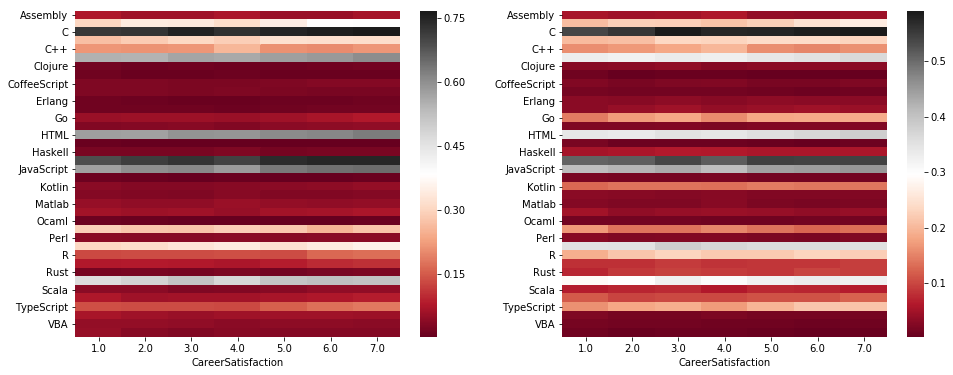

In [209]:
_, axes = plt.subplots(1, 2, figsize=(16,6), sharey=False, ) 
sns.heatmap(langs_worked_percent, ax=axes[0], cmap='RdGy')
sns.heatmap(lang_desired_percent, ax=axes[1], cmap='RdGy')

OS corellations and differences by satisfaction levels.

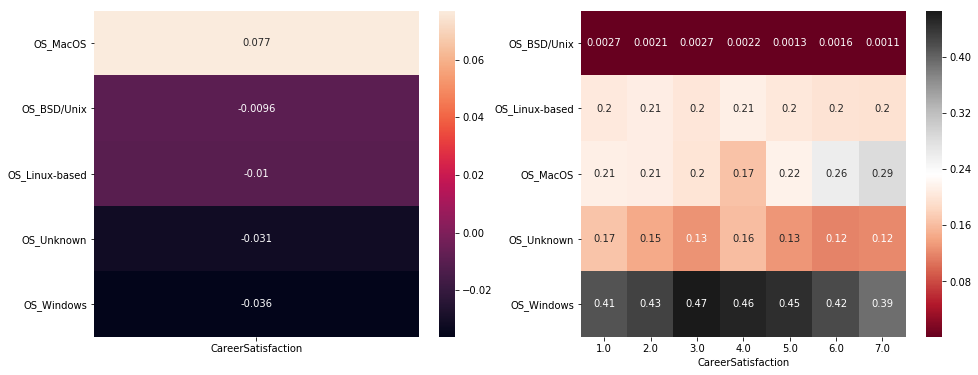

In [210]:
_, axes = plt.subplots(1, 2, figsize=(16,6), sharey=False) 
sns.heatmap(os_correlation.iloc[1:].to_frame(), ax=axes[0], annot=True)
sns.heatmap(satisfaction_os_percent.transpose(), ax=axes[1], cmap='RdGy', annot=True)

#### 3.4 Some other factors correlation heatmaps.

In [211]:
corporative_cols = [
    'CareerSatisfaction',
    'Student',
    'Employment',
    'JobSearchStatus',
    'HopeFiveYears',
    'UpdateCV',
    'SalaryType',
    'Currency'
]

corporative_corellations = \
    full_df[corporative_cols].corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False)

In [212]:
education_cols = [
    'CareerSatisfaction',
    'FormalEducation',
    'UndergradMajor',
    'EducationParents'
]

self_taugh_cols = [st for st in multiselect_columns_descriptions.keys() if st.startswith('SelfTaughtTypes')]
edu_type_cols = [et for et in multiselect_columns_descriptions.keys() if et.startswith('EducationTypes')]

all_edu_cols = education_cols + self_taugh_cols + edu_type_cols
edu_correlation = \
    full_df[all_edu_cols].corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False).rename(
        'Education')
edu_correlation_descriptions = edu_correlation.rename(index=multiselect_columns_descriptions)

In [213]:
edu_correlation_descriptions

CareerSatisfaction                                                                                    1.000000
Contributed to open source software                                                                   0.089353
Received on-the-job training in software development                                                  0.074706
Questions & answers on Stack Overflow                                                                 0.068967
Participated in a hackathon                                                                           0.066886
Taught yourself a new language, framework, or tool without taking a formal course                     0.066712
The official documentation and/or standards for the technology                                        0.066419
Tapping your network of friends, family, and peers versed in the technology                           0.048511
The technology’s online help system                                                                   0.034922
O

In [214]:
social_cols = [
    'CareerSatisfaction',
    'Country',
    'Dependents',
    'MilitaryUS'
]

social_corelation = \
    full_df[social_cols].corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False).rename(
        "Social Factors")

In [215]:
philosophic_cols = [
    'CareerSatisfaction',
    'AIDangerous',
    'AIInteresting',
    'AIResponsible',
    'AIFuture',
    'EthicsChoice',
    'EthicsReport',
    'EthicsResponsible',
    'EthicalImplications'
]

philosophic_corelation = \
    full_df[philosophic_cols].corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False).rename(
        "Philosophic questions")

In [216]:
stackoverflow_cols = [
    'CareerSatisfaction',
    'StackOverflowVisit',
    'StackOverflowHasAccount',
    'StackOverflowParticipate',
    'StackOverflowJobs',
    'StackOverflowDevStory',
    'StackOverflowConsiderMember'
]

stackoverflow_corelation = \
    full_df[stackoverflow_cols].corr(method='spearman')['CareerSatisfaction'].sort_values(ascending=False).rename(
        'StackOverflow questions')

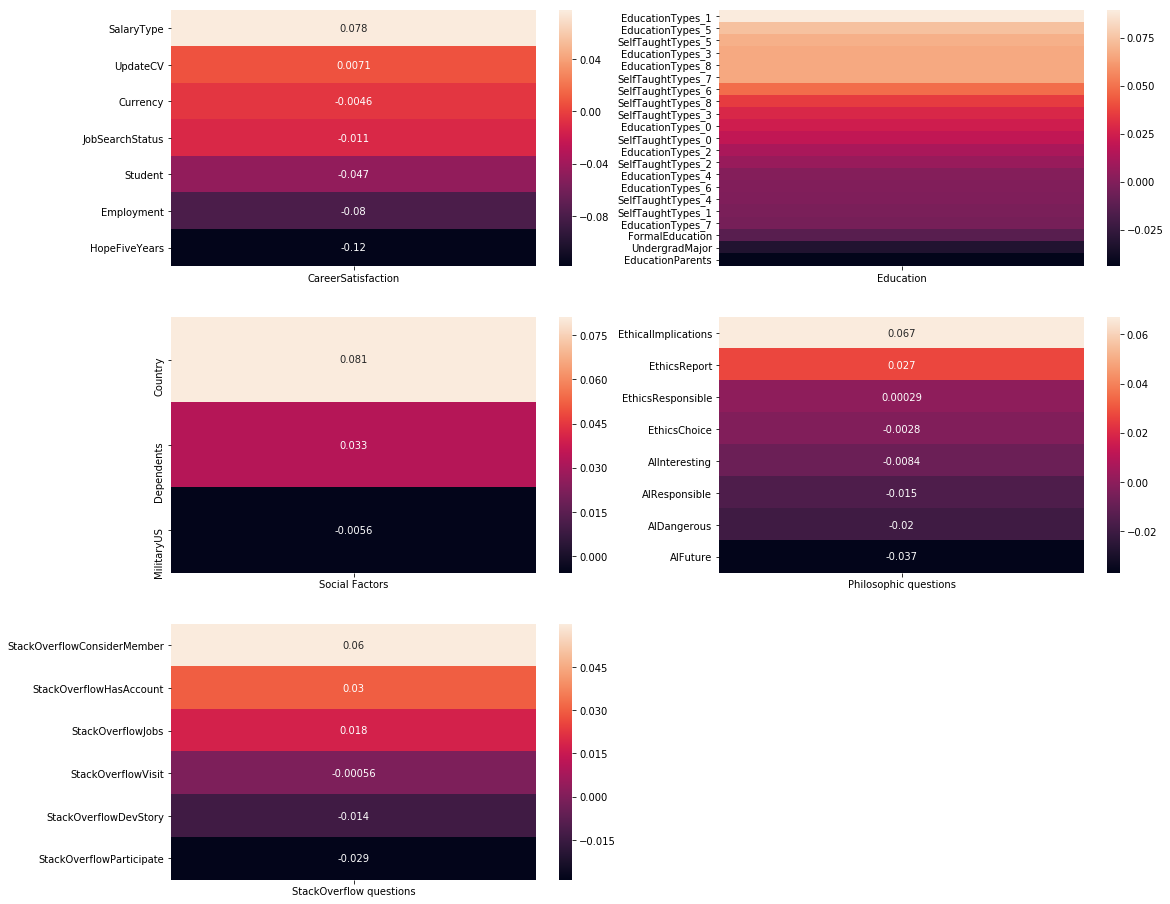

In [217]:
_, axes = plt.subplots(3, 2, figsize=(18,16), sharey=False) 

sns.heatmap(corporative_corellations.to_frame().iloc[1:], ax=axes[0,0], annot=True)
sns.heatmap(edu_correlation.to_frame().iloc[1:], ax=axes[0,1])
sns.heatmap(social_corelation.to_frame().iloc[1:], ax=axes[1,0], annot=True)
sns.heatmap(philosophic_corelation.to_frame().iloc[1:], ax=axes[1,1], annot=True)
sns.heatmap(stackoverflow_corelation.to_frame().iloc[1:], ax=axes[2,0], annot=True)
axes[2,1].set_visible(False)

Not so much in general, but there are features with 0.06 - 0.08 correlations.

#### 3.5 Conclusions

This way, we see a dataset wit a discrete distribution of target variable that shows slight characteristics of Poisson function. <br/>
The most correlated feature is numerical continious <b>ConvertedSalary</b> feature with the 0.182913 correlation value. It has to be cleared out of outliers.<br/>
Among numerical category variables the highest level is shown by the <b>NumbersOfMonitors</b> - 0.090212. Countplots with this feature shows some differences among satisfaction levels as well.<br/>
The highest levels of correlation in technical characteristics are about 0.04-0.05, some of them are not correlated with career satisfaction at all. There are some tech-related difference among satisfaction levels, one of the most noticeable is percentage of <b>MacOS</b> users among highly-satisfied respondents.<br/>
Some other aspects from educational strategies, social factors, country of living, philosophical outlook, StackOverflow membership etc. can correlate with career satisfaction as well, up to 0.06-0.08 values.

###  Part 4. Insights and found dependencies <a id='part4'></a>

Combining the observation from the previous paragraphs, the following is to be denoted:<ul>
<li>The dataset under analysis contain many omissions. That's no wonder: the data came from a voluntary survey, where many questions can be optional. This omissions have to be handled when working with the specific selected model.</li>
<li>The distribution of the target feature, <b>CareerSatisfaction</b> is discrete distribution and it isn't normal or lognormal. That should be taken into account in model selection, as not all models handle non-normal distributions well.</li>
<li>The <b>JobSatisfaction</b> and <b>CareerSatisfaction</b> columns seems to be interconnected features, but the model predicting one of them based on anoter will not be so interesting. It's better to try drawing a conclusion using wide range of other factors first.</li>
<li>The feature with the next level of correlation with the target variable is <b>ConvertedSalary</b>. It is continious float feature but its correlation with levels of satisfaction is non-linear. Unfortunately, it has 0.386 part of NAN values and there are outliers. Hopping that it's partly due to difficulties of manual convertion and <b>Salary</b> column along with <b>Currency</b> and <b>SalaryType</b> will help soften those problems.</li>
<li>By now, other features are categorical with numeric labels, in some cases supporting ordering and ratio relationships, in some cases not. Some of them show non-zero correlation with career satisfaction and differences across satisfaction levels, some do not. Due to lage number of features it is too difficult to select most useful ones before starting the close work with concrete model. It is better to use all of them initially and then exclude/convert some according to practical results/observations/strategies.</li>
</ul>

### Part 5. Metrics selection<a id='part5'></a>

<p>First of all, it should be specified that it is the task of <b>multiclass classification</b>. For some extent, predicting a satisfaction level can be seen as a <i>regression</i> task, as satisfaction is monothonicaly increasing function and it's better to erroneously predict the closest grade then the arbitrary one. But the analysis above shows that there is no linear correlation between features and satisfaction level, rather there are patterns inherent to respondents giving this or that rating.</p>  
<p>One of the most frequently used and simple metric for classification is <b>Accuracy</b>. Unfortunately, it can work badly in the case of inbalanced classes, and the survey dataset is indeed unbalanced (see the distribution histogram).</p>
<p>Another popular classification metric is <b>ROC-AUC</b>. It evaluates correct positive results among all positive samples (True Positive Rate) against incorrect positive results among all negatives (False Positive Rate). However, this task is not the credit scoring one, false positives will not cause missed profit, and we are interested to increased the true positives over the whole set much more than decreasing false triggering. In addition ROC-AUC is initially a binary classification metric, and to use it in multiclassification task additional steps are needed (micro/macro-averaging, binary encoding etc.). This applies to many other binary classification metrics, extended to multiclass case.</p>
<p>One more metric is <b>multiclass logarithmic loss</b>. It can be explained by the formula:
$$\mathcal logloss = -\dfrac{1}{N}\sum_{i=1}^N\sum_{j=1}^M y_{ij}\log(p_{ij})$$
($N$ is the number of observations in the test set, $M$ is the number of class labels, $y_{ij}$ is 1 if observation $i$ belongs to class $j$ and 0 otherwise, and $p_{ij}$ is the predicted probability that observation $i$ belongs to class $j$)
It involves probability estimates and looks interesting in such case. Career satisfaction is something subjective, non-predetermined, evaluated differently by different people in the same circumstances (and even by the same person in different mood). So some uncertainty is present and it usage in the evaluation metric can be helpfull.</p>
<p>Thus, metric selected for evaluating this task is <b>multiclass logarithmic loss.</b><p>

### Part 6. Model selection<a id='part6'></a> 

<p>Human satisfaction seems to be very complicated thing, depending on different combinations of many factors. So this task doesn't look like linearly separable and non-linear model has to be selected, the one that allows to avoid tricks like polynomyal features and kernel change. The most popular non-linear models nowadays are ensembles of decision trees.</p>
<p>For the sake of easy reproducibility and without need to handle gigabytes of data or fighting for thousandth fractions of metric in the competition, this task is going to be solved by the means of scikit-learn library, without Vopal Wabbit, XGBoost etc. From tree ensembles presented in scikit-learn the <b>RandomForestClassifier</b> looks like the most obvious selection. Beside handling nonlinearity Random Forest offers some other advantages:<ul><li>After a random split, only subset of features are selected, that is useful when there are so many of them;</li>
<li>Conditions in decisions handle both continuous and discrete variables;</li>
<li>Doesn't need feature rescaling;</li>
<li>Is said to work well with non-normal target distribution;</li>
<li>Robust to outliers and large amount of missing data;</li>
<li>There are developed methods to estimate feature importance;</li></ul></p>

### Part 7. Data preprocessing<a id='part7'></a>

#### 7.1 Data handling

In fact, the most part of data preprocessing was done on the [features convertion step](#features_conversion) above primary data analysis (otherwise the analysis wouldn't be possible at all). There can be found replacing some strings with numbers using LabelEncoder, mapping other strings to numeric categories with order and ratio relationships, converting columns with multiple options to the sets of 1/0 columns (similar to One-Hot Encoding but not that exactly), mapping Yes/No columns to 1/0 columns, simple string processing to parse "almost numeric" string columns to numeric columns, etc.<br> 

There are a lot of columns with NAN value. Features with large amount of missed data do not bring much usefull information, but increase the computational complexity. So, cut off those with amount of NAN > 0.4

In [88]:
cols_too_many_nans = full_df.isna().mean()
cols_too_many_nans = cols_too_many_nans[cols_too_many_nans > 0.4].index.values

In [89]:
preprocessed_df = full_df.drop(columns=cols_too_many_nans)

Fill other NANs with zeros as the simple strategy. (To be honest I've tried other ones, but they didn't show significantly better results)

In [90]:
preprocessed_df = preprocessed_df.fillna(0)

During the visual analysis it was [found](#ConvertedSalaryVisual) that it's better to clear ConvertedSalary column from outliers. Let's incorporate it into the dataset.

In [91]:
quantile_95 = preprocessed_df['ConvertedSalary'].quantile(0.95)
preprocessed_df['ConvertedSalary'] = preprocessed_df['ConvertedSalary'].map(lambda cs: min(cs, quantile_95))

The same for 'Salary' column.

In [92]:
quantile_95 = preprocessed_df['Salary'].quantile(0.95)
preprocessed_df['Salary'] = preprocessed_df['Salary'].map(lambda cs: min(cs, quantile_95))

RandomForestClassifier in sklearn library doesn't handle unordered numerical category features well, so they have to be converted to One-Hot Encoding using pd.get_dummies:

In [93]:
preprocessed_df = pd.get_dummies(preprocessed_df, columns = categorize_cols, drop_first=True,
                            prefix=categorize_cols, sparse=False)

In [94]:
preprocessed_df.head()

,CareerSatisfaction,Hobby,OpenSource,Dependents,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,...,EducationParents_8,EducationParents_9,SurveyTooLong_1,SurveyTooLong_2,SurveyTooLong_3,SurveyEasy_1,SurveyEasy_2,SurveyEasy_3,SurveyEasy_4,SurveyEasy_5
Respondent,,,,,,,,,,,,,,,,,,,,,
1,7.0,1,0,1.0,10.0,7.0,8.0,1.0,2.0,5.0,...,0,0,0,0,0,0,0,0,0,1
3,4.0,1,1,1.0,1.0,7.0,10.0,8.0,2.0,5.0,...,0,0,0,0,0,0,1,0,0,0
4,6.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,1,0,0
5,3.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
7,6.0,1,0,1.0,8.0,5.0,7.0,1.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0


#### 7.2 Dividing the data into training and hold-out sets

In [95]:
print("Preprocessed dataset shape:", preprocessed_df.shape)

Preprocessed dataset shape: (76504, 712)


There are 76504 rows in the preprocessed dataset. Let's separate 0.3 part of them into hold-out set. Respondents anwers are totaly independent from each other and from time characteristics, but the way records are listed is unknown, thus it's good to randomly shuffle them first.

In [97]:
# calling sample() with frac=1 will just shuffle all rows
preprocessed_df = preprocessed_df.sample(frac=1, random_state=17)

train_part_size = int(0.7 * preprocessed_df.shape[0])

train_df = preprocessed_df[:train_part_size]
test_df = preprocessed_df[train_part_size:]

print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)

train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

Train shape:  (53552, 712)
Test shape:  (22952, 712)


In [ ]:
del test_df

### Part 8. Cross-validation and adjustment of model hyperparameters<a id='part8'></a>

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss

In [99]:
train_df = pd.read_csv('train.csv', index_col='Respondent')

#### 8.1 Initial evaluation of the model

First of all, evaluating the model "as is"

In [100]:
train_part = train_df.sample(frac=0.8, random_state=17)
validation_part = train_df.drop(train_part.index)

In [101]:
y_train = train_part['CareerSatisfaction']
X_train = train_part.drop(columns=['CareerSatisfaction'])

y_valid = validation_part['CareerSatisfaction']
X_valid = validation_part.drop(columns=['CareerSatisfaction'])

print("Train: ", X_train.shape, y_train.shape)
print("Test: ", X_valid.shape, y_valid.shape)

Train:  (42842, 711) (42842,)
Test:  (10710, 711) (10710,)


In [102]:
random_forest = RandomForestClassifier(random_state=17)

In [103]:
%%time 
random_forest.fit(X_train, y_train)

CPU times: user 2.73 s, sys: 156 ms, total: 2.89 s
Wall time: 3.11 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [104]:
y_pred = random_forest.predict_proba(X_valid)

In [105]:
log_loss(y_valid, y_pred)

6.8741212005329855

Doesn't look like too good result. Create some simple baselines to compare with

In [45]:
y_six_baseline = np.zeros(y_pred.shape)
y_six_baseline[:, 5] = 1.0

In [46]:
y_random_baseline = np.random.random_sample(y_pred.shape)

In [47]:
y_equal_likely_baseline = np.full(y_pred.shape, fill_value=1/y_pred.shape[1])

In [48]:
y_no_one_baseline = np.zeros(y_pred.shape)

In [50]:
print("All 6.0 baseline: ", log_loss(y_valid, y_six_baseline))
print("Random baseline: ", log_loss(y_valid, y_random_baseline))
print("Equaly likely baseline: ", log_loss(y_valid, y_equal_likely_baseline))
print("No one baseline: ", log_loss(y_valid, y_no_one_baseline))

All 6.0 baseline:  22.235748201952312
Random baseline:  2.2173541717971172
Equaly likely baseline:  1.9459101490553126
No one baseline:  1.945910149055314


It looks like logloss strongly penalizes constant-dominant-class predictor. But in general, results of the initial RandomForestClassifier are not good at all.<br/>
But the classifier was trained too quickly, in ~3s. It has n_estimators=10, may be it's too few for such a large amount of features?

In [24]:
random_forest = RandomForestClassifier(random_state=17, n_estimators=200)

In [94]:
%%time 
random_forest.fit(X_train, y_train)

CPU times: user 49.6 s, sys: 344 ms, total: 49.9 s
Wall time: 49.9 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

In [96]:
y_pred = random_forest.predict_proba(X_valid)
initial_score = log_loss(y_valid, y_pred)
initial_score

1.6535629549525597

That gives hope. Running GridSearchCV to tune hyperparameters.

#### 8.2 Hyperparameters tuning

In [52]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

 Using 3 splits as one of the most frequently used amount, shuffle samples in random order. 

In [ ]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)
tree_params = {
    'n_estimators' : [250, 300, 350],
    'max_depth' : [None, 10, 20],
    'max_features' : ['sqrt', 'log2', 50]
}
gcv = GridSearchCV(random_forest, tree_params, scoring='neg_log_loss', cv=skf, verbose=1)
gcv.fit(X_crossvalid, y_crossvalid)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [23]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=20, max_features=50, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=1,
             oob_score=False, random_state=17, verbose=0, warm_start=False),
 -1.6281354697593482)

It looks like more complex model performs better. However, increasing of its complicity leads to the exhaustion of computing power and rising of MemoryErros. Staying with these parameters. 

Split with 3 folds was used to reduce parameters search time. Cross-validation can be run with large amount of splits.

In [54]:
skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_scores = cross_val_score(gcv.best_estimator_, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

In [55]:
print(cv_scores)
print(np.mean(cv_scores))

[-1.62650046 -1.63022187 -1.62912835 -1.61962302 -1.61858969]
-1.6248126771219151


Cross-validation shows quite stable predictions values.

#### 8.3 Confusion matrix <a id="confusion_matrix" ></a>

One more way to evaluate prediction results is a <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html">confusion matrix</a>, that allows to see what classes are mixed out with each other the most often.

In [77]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [55]:
def evaluate_predictions(estimator, X, y, X_validation, y_validation):
    estimator.fit(X, y)
    y_pred = estimator.predict(X_validation)
    y_pred_proba = estimator.predict_proba(X_validation)
    
    cm = confusion_matrix(y_validation, y_pred)
    log_loss_value = log_loss(y_validation, y_pred_proba)
    
    # Convert matrix values to fractions due to different amount of samples accros classes.
    counts = cm.sum(axis=1)
    counts = counts.reshape(-1,1)
    sns.heatmap(cm / counts, annot=True)
    print("LogLoss value: ", log_loss_value)

LogLoss value:  1.631079060634029


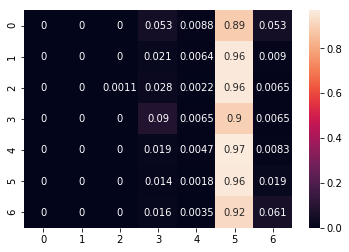

In [36]:
evaluate_predictions(gcv.best_estimator_, X_train, y_train, X_valid, y_valid)

Not a beatiful picture. The most predictions were just attributed to the prevalent class. Maybe some samples balancing will help?

In [60]:
def balance_dataset(df):

    levels_counts = df['CareerSatisfaction'].value_counts().to_dict()
    mean_level_count = int(np.mean(list(levels_counts.values())))

    balanced_df = pd.DataFrame()

    for level in levels_counts.keys():
        level_rows = df[df['CareerSatisfaction']==level]
    
        level_df = level_rows.sample(n=mean_level_count, random_state=17, replace=True)

        index_start = 1 if balanced_df.empty else balanced_df.index[-1] + 1
        level_df = pd.DataFrame(
            index=range(index_start, index_start + mean_level_count),
            data=level_df.values,
            columns = df.columns
        )
        
        balanced_df = balanced_df.append(level_df)
    
    # randomly shuffle
    balanced_df = balanced_df.sample(frac=1.0, random_state=17)
        
    return balanced_df

In [38]:
train_balanced = balance_dataset(train_part)
print(train_balanced['CareerSatisfaction'].value_counts())
print(train_balanced.shape, validation_part.shape)

7.0    6120
3.0    6120
5.0    6120
1.0    6120
2.0    6120
4.0    6120
6.0    6120
Name: CareerSatisfaction, dtype: int64
(42840, 712) (10710, 712)


In [39]:
y_train_balanced = train_balanced['CareerSatisfaction']
X_train_balanced = train_balanced.drop(columns=['CareerSatisfaction'])

LogLoss value:  1.7597617889670631


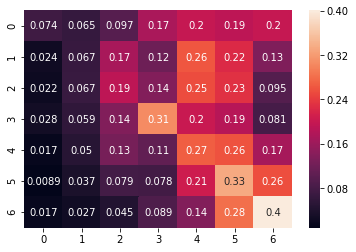

In [40]:
evaluate_predictions(gcv.best_estimator_, X_train_balanced, y_train_balanced, X_valid, y_valid)

Predictions of non-prevalent classes became better due to prevalent class accuracy decrease, but the whole metric became worse as well. <br/>
It looks like current set of features just doesn't contain enough information to distinguish levels of satisfaction confidently. Trying to do something with that.

### Part 9. Creation of new features and description of this process<a id='part9'></a> 

In [7]:
train_df = pd.read_csv('train.csv', index_col='Respondent')

In [8]:
train_df.shape

(53552, 712)

#### 9.1 Amount of skipped questions

If there's a problem of lack of information, maybe the fact of missed information can bring a benefit? <br/> 
Let's see if the average amount of skipped questions is different from one satisfaction level to another.

In [9]:
def get_skipped_questions_amount(df):
    isna_flags = df.drop(columns=['CareerSatisfaction']).isna()
    skipped = isna_flags.sum(axis=1).rename('SkippedQuestions')
    return skipped

In [10]:
full_train_df = full_df.loc[train_df.index]
skipped_questions = get_skipped_questions_amount(full_train_df)

In [11]:
skipped_mean = skipped_questions.mean()
skipped_mean

17.04487227367792

In [12]:
skipped_questions_df = skipped_questions.to_frame()
skipped_questions_df['CareerSatisfaction'] = full_train_df['CareerSatisfaction']
skipped_questions_by_level = skipped_questions_df.groupby('CareerSatisfaction')
skipped_questions_by_level.describe()

SkippedQuestions                                        \
                              count       mean        std  min  25%   50%   
CareerSatisfaction                                                          
1.0                          1848.0  20.348485  20.379023  0.0  4.0  13.0   
2.0                          3714.0  17.715940  19.763913  0.0  3.0   9.0   
3.0                          4613.0  15.719272  19.040307  0.0  3.0   6.0   
4.0                          4426.0  19.266606  20.164159  0.0  4.0  10.0   
5.0                          9395.0  16.241192  18.878519  0.0  3.0   7.0   
6.0                         19546.0  16.228794  18.435652  0.0  3.0  10.0   
7.0                         10010.0  18.162338  18.289217  0.0  4.0  14.0   

                                 
                      75%   max  
CareerSatisfaction               
1.0                 34.25  67.0  
2.0                 27.00  67.0  
3.0                 21.00  67.0  
4.0                 32.00  68.0  
5.0                 21.00  67.0  
6.0                 19.00  68.0  
7.0                 22.00  68.0

In [13]:
less_than_mean_skipped = skipped_questions_df[skipped_questions_df['SkippedQuestions'] < skipped_mean]
less_than_mean_skipped.groupby('CareerSatisfaction').size() / skipped_questions_by_level.size()

CareerSatisfaction
1.0    0.629870
2.0    0.684976
3.0    0.728160
4.0    0.644600
5.0    0.719745
6.0    0.734268
7.0    0.698302
dtype: float64

The amount of respondents skipped more than average amount of questions differs from level to level. Adding this features, evaluating.

In [14]:
train_df['LessThanMeanAnswered'] = \
    skipped_questions_df.loc[train_df.index]['SkippedQuestions'].map(lambda skipped:
        int(skipped < skipped_mean))
train_df['MoreThanMeanAnswered'] = \
    skipped_questions_df.loc[train_df.index]['SkippedQuestions'].map(lambda skipped:
        int(skipped > skipped_mean))

In [18]:
random_forest = RandomForestClassifier(random_state=17, max_depth=20, max_features=50, n_estimators=350)

In [19]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

In [20]:
skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_scores = cross_val_score(random_forest, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

In [21]:
print(cv_scores)
print(np.mean(cv_scores))

[-1.63418229 -1.62929985 -1.62544378 -1.6291633  -1.62368132]
-1.628354106506782


Doesn't seem to give improvement, removing this feature. 

In [22]:
train_df = train_df.drop(columns=['LessThanMeanAnswered', 'MoreThanMeanAnswered'])

#### 9.2 Trying to convert Salary programmatically

The <b>ConvertedSalary</b> column looks like manualy infered by each respondent from <b>Salary</b>, <b>SalaryType</b> and <b>Currency</b>. Maybe there were mistakes; trying to automate the process.

In [111]:
#!pip install currencyconverter

In [23]:
from currency_converter import CurrencyConverter
from datetime import date

converter = CurrencyConverter()
course_date=date(2018, 1, 18)

salary_type_encoder = category_encoders['SalaryType']
currency_encoder = category_encoders['Currency']

In [24]:
salary_type_encoder.classes_

array(['Monthly', 'Unknown', 'Weekly', 'Yearly'], dtype=object)

In [25]:
currency_encoder.classes_

array(['Australian dollars (A$)', 'Bitcoin (btc)', 'Brazilian reais (R$)',
       'British pounds sterling (£)', 'Canadian dollars (C$)',
       'Chinese yuan renminbi (¥)', 'Danish krone (kr)', 'Euros (€)',
       'Indian rupees (₹)', 'Japanese yen (¥)', 'Mexican pesos (MXN$)',
       'Norwegian krone (kr)', 'Polish złoty (zł)', 'Russian rubles (₽)',
       'Singapore dollars (S$)', 'South African rands (R)',
       'Swedish kroner (SEK)', 'Swiss francs', 'U.S. dollars ($)',
       'Unknown'], dtype=object)

In [26]:
currency_map = {
    'Australian dollars (A$)': 'AUD',
    'Bitcoin (btc)': 'XBT',
    'Brazilian reais (R$)': 'BRL',
    'British pounds sterling (£)': 'GBP',
    'Canadian dollars (C$)': 'CAD',
    'Chinese yuan renminbi (¥)': 'CNY',
    'Danish krone (kr)': 'DKK',
    'Euros (€)': 'EUR',
    'Indian rupees (₹)': 'INR',
    'Japanese yen (¥)': 'JPY',
    'Mexican pesos (MXN$)': 'MXN',
    'Norwegian krone (kr)': 'NOK',
    'Polish złoty (zł)': 'PLN',
    'Russian rubles (₽)': 'RUB',
    'Singapore dollars (S$)': 'SGD',
    'South African rands (R)': 'ZAR',
    'Swedish kroner (SEK)': 'SEK',
    'Swiss francs': 'CHF',
    'U.S. dollars ($)': 'USD',
}

In [27]:
def try_convert_salary(df):
    if pd.isna(df['SalaryType']):
        return 0.0    
    salary_type = salary_type_encoder.classes_[int(df['SalaryType'])]
    
    if (pd.isna(df['Salary']) or pd.isna(df['Currency']) or salary_type == 'Unknown'):
        return 0.0
    
    currency = currency_encoder.classes_[int(df['Currency'])]
    if (currency == 'Unknown' or currency == 'Bitcoin (btc)'):
        return 0.0
    
    currency = currency_map[currency]
    
    if currency == 'USD':
        in_usd = df['Salary']
    else:
        in_usd = converter.convert(df['Salary'], currency, 'USD', date=course_date)
    
    if salary_type == 'Yearly':
        return in_usd    
    elif salary_type == 'Monthly':
        return 12 * in_usd
    else:
        return 50 * in_usd    

In [32]:
train_df['AutoconvertedSalary'] = full_train_df.apply(try_convert_salary, axis=1)

In [33]:
quantile_95 = train_df['AutoconvertedSalary'].quantile(0.95)
train_df['AutoconvertedSalary'] = train_df['AutoconvertedSalary'].map(lambda cs: min(cs, quantile_95))

In [34]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

In [35]:
skf_5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [36]:
cv_scores = cross_val_score(random_forest, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

In [37]:
print(cv_scores)
print(np.mean(cv_scores))

[-1.63337175 -1.62900048 -1.62722743 -1.62910953 -1.62575021]
-1.6288918812550075


The worsening is noticeable. It's better not to add the feature.

In [38]:
train_df = train_df.drop(columns=['AutoconvertedSalary'])

#### 9.3 Secondary features using experience columns

The <b>YearsCoding</b>, <b>YearsCodingProf</b>, <b>LastNewJob</b> and <b>Age</b> didn't show to hight correlation with the target feature, but maybe their ratios contains any usefull patterns?

In [39]:
train_df['CodingProportion'] = train_df.apply(lambda df:
    0.0 if pd.isna(df['YearsCoding']) or pd.isna(df['Age']) or (df['Age'] == 0)
        else df['YearsCoding']/ df['Age'],
    axis=1)

train_df['ProfProportion'] = train_df.apply(lambda df:
    0.0 if pd.isna(df['YearsCodingProf']) or pd.isna(df['YearsCoding']) or (df['YearsCoding'] == 0)
        else df['YearsCodingProf'] / df['YearsCoding'],
    axis=1)

train_df['LastJobProportion'] = train_df.apply(lambda df:
    0.0 if pd.isna(df['LastNewJob']) or pd.isna(df['Age']) or (df['Age'] == 0)
        else df['LastNewJob'] / df['Age'],
    axis=1)

In [42]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

cv_scores = cross_val_score(random_forest, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

print(cv_scores)
print(np.mean(cv_scores))

[-1.63293954 -1.6291314  -1.62552157 -1.6318263  -1.62324109]
-1.6285319781532475


Doesn't seem to give increase.

In [43]:
train_df = train_df.drop(columns=['CodingProportion', 'ProfProportion', 'LastJobProportion'])

#### 9.4 Adding JobSatisfaction feature

As all other attempts didn't help, adding the <b>JobSatisfaction</b> column as the last resort, though initial intent was not to use this obvious feature. 

In [46]:
job_satisfaction = survey_results['JobSatisfaction'].map(satisfaction_map).fillna(0.0)
train_df['JobSatisfaction'] = job_satisfaction.loc[train_df.index]

In [47]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

In [105]:
cv_scores = cross_val_score(random_forest, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

print(cv_scores)
print(np.mean(cv_scores))

[-1.49881005 -1.49754313 -1.49616572 -1.48898074 -1.48607919]
-1.4935157648402513


Relatively high model improvement, as expected.

In [48]:
test_df = pd.read_csv('test.csv', index_col='Respondent')

In [49]:
test_df['JobSatisfaction'] = job_satisfaction.loc[test_df.index]
test_df.head()

,CareerSatisfaction,Hobby,OpenSource,Dependents,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,...,EducationParents_9,SurveyTooLong_1,SurveyTooLong_2,SurveyTooLong_3,SurveyEasy_1,SurveyEasy_2,SurveyEasy_3,SurveyEasy_4,SurveyEasy_5,JobSatisfaction
Respondent,,,,,,,,,,,,,,,,,,,,,
17971,6.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,6.0
35830,2.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,2.0
78890,5.0,0,0,0.0,8.0,7.0,2.0,4.0,1.0,3.0,...,0,1,0,0,1,0,0,0,0,6.0
75148,4.0,1,1,1.0,7.0,6.0,9.0,8.0,2.0,3.0,...,0,0,0,0,0,1,0,0,0,3.0
100409,3.0,0,0,0.0,9.0,6.0,2.0,5.0,4.0,1.0,...,0,1,0,0,0,1,0,0,0,3.0


In [50]:
test_df.to_csv('test.csv')

In [ ]:
del test_df

#### 9.5 Decreasing amount of target classes

As feature engineering doesn't bring much outcome, and low-ranking classes are too small, decreasing granularity of target variable looks like a admissible approach.<br/>
So, uniting and remaping target classes as:<ul>
<li>1-3, namely "dissatisfied", with the new value "1"</li>
<li>4-5, "middling satisfied", with value "2"</li>
<li>Leaving 6 and 7 left as is separate classes ("Moderately satisfied" and "Extremely satisfied") with new values "3" and "4"</li></ul>

In [51]:
lower_granularity_map = {
    1.0 : 1.0,
    2.0 : 1.0,
    3.0 : 1.0,
    4.0 : 2.0,
    5.0 : 2.0,
    6.0 : 3.0,
    7.0 : 4.0
}

In [52]:
train_df['CareerSatisfaction'] = train_df['CareerSatisfaction'].map(lower_granularity_map)

In [53]:
y_crossvalid = train_df['CareerSatisfaction']
X_crossvalid = train_df.drop(columns=['CareerSatisfaction'])

cv_scores = cross_val_score(random_forest, X_crossvalid, y_crossvalid, cv=skf_5, scoring='neg_log_loss')

print(cv_scores)
print(np.mean(cv_scores))

[-1.16274709 -1.16683842 -1.16263035 -1.16241163 -1.15532128]
-1.1619897550013043


That looks better. Evaluating confusion matrix:

LogLoss value:  1.1580000908041657


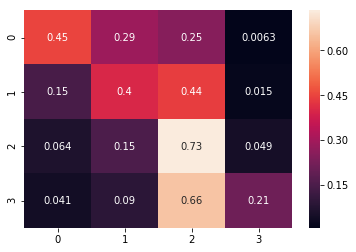

In [58]:
train_part = train_df.sample(frac=0.8, random_state=17)
validation_part = train_df.drop(train_part.index)

y_train = train_part['CareerSatisfaction']
X_train = train_part.drop(columns=['CareerSatisfaction'])

y_valid = validation_part['CareerSatisfaction']
X_valid = validation_part.drop(columns=['CareerSatisfaction'])

evaluate_predictions(random_forest, X_train, y_train, X_valid, y_valid)

Again, the "Moderately satisfied" rank gets the most confusion values, though they became lower than classifying to 7 classes. <br/>
What if balance classes in train part?

LogLoss value:  1.188879399371357


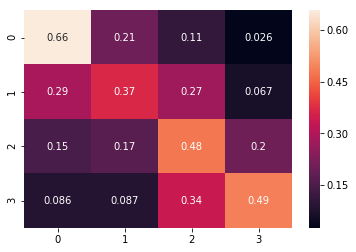

In [61]:
train_balanced = balance_dataset(train_part)

y_train_balanced = train_balanced['CareerSatisfaction']
X_train_balanced = train_balanced.drop(columns=['CareerSatisfaction'])

evaluate_predictions(random_forest, X_train_balanced, y_train_balanced, X_valid, y_valid)

The metric value decreased, but now not only the prevalent class is detected more confidently. What is more important, low-satisfaction classes are more easily distingushed from high-satisfaction ones.

Compare with baselines of 4 classes: 

In [62]:
y_pred = random_forest.predict_proba(X_valid)

In [63]:
y_three_baseline = np.zeros(y_pred.shape)
y_three_baseline[:, 2] = 1.0

y_random_baseline = np.random.random_sample(y_pred.shape)

y_equal_likely_baseline = np.ones(y_pred.shape)

y_no_one_baseline = np.zeros(y_pred.shape)

print("All 3.0 baseline: ", log_loss(y_valid, y_three_baseline))
print("Random baseline: ", log_loss(y_valid, y_random_baseline))
print("Equal likely baseline: ", log_loss(y_valid, y_equal_likely_baseline))
print("No one baseline: ", log_loss(y_valid, y_no_one_baseline))

All 3.0 baseline:  21.855208928880455
Random baseline:  1.6604943733636561
Equal likely baseline:  1.3862943611198906
No one baseline:  1.3862943611198906


Anyway, the model performs better.

In [64]:
test_df = pd.read_csv('test.csv', index_col='Respondent')

In [65]:
test_df['CareerSatisfaction'] = test_df['CareerSatisfaction'].map(lower_granularity_map)
test_df.head()

,CareerSatisfaction,Hobby,OpenSource,Dependents,AssessJob1,AssessJob2,AssessJob3,AssessJob4,AssessJob5,AssessJob6,...,EducationParents_9,SurveyTooLong_1,SurveyTooLong_2,SurveyTooLong_3,SurveyEasy_1,SurveyEasy_2,SurveyEasy_3,SurveyEasy_4,SurveyEasy_5,JobSatisfaction
Respondent,,,,,,,,,,,,,,,,,,,,,
17971,3.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,0,0,1,0,0,6.0
35830,1.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0,0,0,2.0
78890,2.0,0,0,0.0,8.0,7.0,2.0,4.0,1.0,3.0,...,0,1,0,0,1,0,0,0,0,6.0
75148,2.0,1,1,1.0,7.0,6.0,9.0,8.0,2.0,3.0,...,0,0,0,0,0,1,0,0,0,3.0
100409,1.0,0,0,0.0,9.0,6.0,2.0,5.0,4.0,1.0,...,0,1,0,0,0,1,0,0,0,3.0


In [66]:
test_df.to_csv('test.csv')

In [67]:
del test_df

### Part 10. Plotting training and validation curves<a id='part10'></a>

#### 10.1 Facilities for plotting

In [57]:
import time
from sklearn.metrics import confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [69]:
class LearningCurve:
    def __init__(self, variable_parameter_name, unaltered_parameters, X, y):
        self.variable_parameter_name = variable_parameter_name
        self.parameters_dict = dict(unaltered_parameters)
        self.X = X
        self.y = y
        self.parameter_values = []
        self.train_metrics_mean = []
        self.test_metrics_mean = []
        self.learning_times_mean = []
        
    def add_learning_point(self, parameter_value, splits=3):      
        self.parameter_values.append(parameter_value)
        
        self.parameters_dict[self.variable_parameter_name] = parameter_value
        estimator = RandomForestClassifier(**self.parameters_dict)
        
        train_metrics = []
        test_metrics = []
        learning_times = []
        
        k_fold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=17)
        
        for train_index, test_index in k_fold.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                                    
            learn_start = time.perf_counter()
            estimator.fit(X_train, y_train)
            learn_end = time.perf_counter()
            
            learning_times.append(learn_end - learn_start)
            
            metric_on_train = log_loss(y_train, estimator.predict_proba(X_train))
            train_metrics.append(metric_on_train)
            
            metric_on_test = log_loss(y_test, estimator.predict_proba(X_test))
            test_metrics.append(metric_on_test)
            
        self.train_metrics_mean.append(np.mean(train_metrics)),
        self.test_metrics_mean.append(np.mean(test_metrics)),
        self.learning_times_mean.append(np.mean(learning_times))
        
    def get_best_point(self):
        best_test_metric = min(self.test_metrics_mean)
        i = self.test_metrics_mean.index(best_test_metric)
        return {
            'value': self.parameter_values[i],
            'test_metric': best_test_metric,
            'train_metric' : self.train_metrics_mean[i],
            'learning_time' : self.learning_times_mean[i]
        }
    
    def get_curve_points(self):
        points = []
        for i in range(0, len(self.parameter_values)):
            point = {
                'value': self.parameter_values[i],
                'test_metric': self.test_metrics_mean[i],
                'mean_train_metric': self.train_metrics_mean[i],
                'learning_time': self.learning_times_mean[i]
            }
            points.append(point)
        return points

In [90]:
class Plotter:
    def plot_curve(self, curve, separately=False, learning_time=True, ylim=[0, 1.9]):               
        plt.style.use('ggplot')
        
        axes_count = 1
        validation_axes = 0
        if separately:
            axes_count += 1
            validation_axes = 1
            
        if learning_time:
            axes_count += 1
            
        fig, axes = plt.subplots(1, axes_count, figsize=(12, 6), sharey=False)
        
        axes[0].plot(curve.parameter_values, curve.train_metrics_mean, alpha=0.5, color='blue', label='train')
        
        axes[validation_axes].plot(
            curve.parameter_values, curve.test_metrics_mean, alpha=0.5, color='red', label='validation')
        
        for i in range (0, validation_axes + 1):
            axes[i].set_ylabel("LogLoss")
            axes[i].set_xlabel(curve.variable_parameter_name)
            axes[i].legend(loc='best')
            axes[i].set_ylim(ylim)
        
        if learning_time:
            axes[axes_count-1].plot(
                curve.parameter_values, curve.learning_times_mean, alpha=0.5, color='green', label='learning_time')
            axes[axes_count-1].set_ylabel("Learning time")
            axes[axes_count-1].set_xlabel(curve.variable_parameter_name)
            axes[axes_count-1].legend(loc='best')

In [71]:
y = train_df['CareerSatisfaction']
X = train_df.drop(columns=['CareerSatisfaction'])

#### 10.2 Parameter 'n_estimators'

In [166]:
unaltered_params = {"random_state": 17}
estimators_curve = LearningCurve('n_estimators', unaltered_params, X, y)

for estimators in [10, 150, 350, 400]:
    estimators_curve.add_learning_point(estimators)

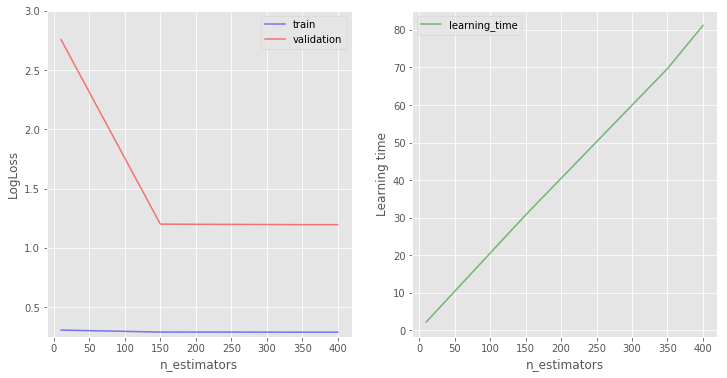

In [88]:
Plotter().plot_curve(estimators_curve, ylim=[0.25, 3])

Due to different scale it hard to see the training curve behavior. Plotting separately.

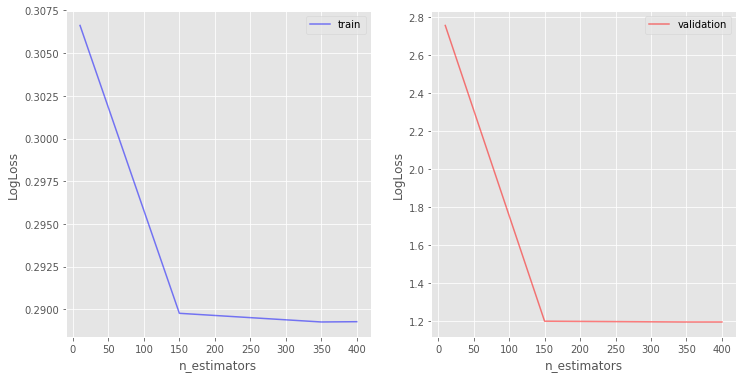

In [92]:
Plotter().plot_curve(estimators_curve, separately=True, learning_time=False, ylim=None)

In [171]:
estimators_curve.get_curve_points()

[{'value': 10,
  'test_metric': 2.7555473848671954,
  'mean_train_metric': 0.3066192180828405,
  'learning_time': 2.179833531333619},
 {'value': 150,
  'test_metric': 1.1998008800697488,
  'mean_train_metric': 0.2897673506180998,
  'learning_time': 30.692830163000206},
 {'value': 350,
  'test_metric': 1.1958122418066297,
  'mean_train_metric': 0.2892594331976898,
  'learning_time': 69.69056631099981},
 {'value': 400,
  'test_metric': 1.1958581869927603,
  'mean_train_metric': 0.28927608513249,
  'learning_time': 81.18399305133364}]

Such difference in metric improvement can be an indicator of overfitting. Analysing max_depth parameter as one of the affecting overfitting parameters.

#### 10.3 Parameter 'max_depth'

In [93]:
unaltered_params = {"random_state": 17, 'n_estimators': 350}
depth_curve = LearningCurve('max_depth', unaltered_params, X, y)

for depth in [5, 10, 20, 50, 70, 100]:
    depth_curve.add_learning_point(depth)

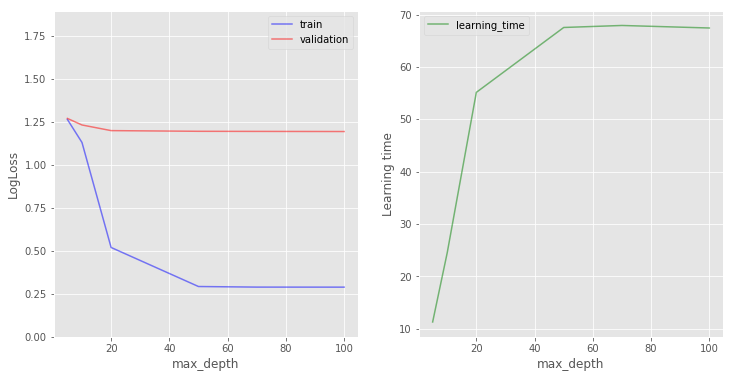

In [94]:
Plotter().plot_curve(depth_curve)

In [95]:
depth_curve.get_curve_points()

[{'value': 5,
  'test_metric': 1.2720989127327094,
  'mean_train_metric': 1.2659926781473894,
  'learning_time': 11.306356675333214},
 {'value': 10,
  'test_metric': 1.2339634150818322,
  'mean_train_metric': 1.132118911340317,
  'learning_time': 24.51164071033342},
 {'value': 20,
  'test_metric': 1.2011113766800818,
  'mean_train_metric': 0.5203746578997891,
  'learning_time': 55.16383692399995},
 {'value': 50,
  'test_metric': 1.1970960601259997,
  'mean_train_metric': 0.2929399108016048,
  'learning_time': 67.55816714699995},
 {'value': 70,
  'test_metric': 1.1965182536355152,
  'mean_train_metric': 0.2894953857886989,
  'learning_time': 67.943045472},
 {'value': 100,
  'test_metric': 1.1958122418066297,
  'mean_train_metric': 0.2892594331976898,
  'learning_time': 67.45972251733353}]

It looks like lower value of max_depth helps to fight overfitting on the train set, but worsen test metric as well. The first doesn't seem so worthy to sacrifice the second.

#### 10.4 Parameter 'max_features'

In [180]:
unaltered_params = {"random_state": 17, 'n_estimators': 350}
features_curve = LearningCurve('max_features', unaltered_params, X, y)

for features in [25, 50, 100, 150]:
    point = features_curve.add_learning_point(features)

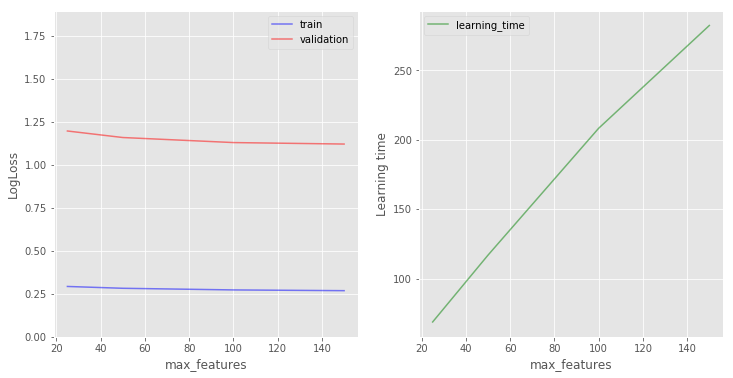

In [181]:
Plotter().plot_curve(features_curve)

In [184]:
features_curve.get_curve_points()

[{'value': 25,
  'test_metric': 1.1988543218598207,
  'mean_train_metric': 0.29327914606021727,
  'learning_time': 68.98764606866825},
 {'value': 50,
  'test_metric': 1.1608890268628482,
  'mean_train_metric': 0.2826457664413078,
  'learning_time': 117.0776869349999},
 {'value': 100,
  'test_metric': 1.1314695355647197,
  'mean_train_metric': 0.2730755541656979,
  'learning_time': 208.40414415433406},
 {'value': 150,
  'test_metric': 1.1228367080986985,
  'mean_train_metric': 0.26874561903927136,
  'learning_time': 282.38923534033165}]

#### 10.5 Parameter 'min_samples_split '

In [96]:
unaltered_params = {"random_state": 17, 'n_estimators': 350, 'max_features':150 }
split_curve = LearningCurve('min_samples_split', unaltered_params, X, y)

for split in [2, 4, 16, 32, 64]:
    point = split_curve.add_learning_point(split)

In [98]:
split_curve.get_curve_points()

[{'value': 2,
  'test_metric': 1.1231902235607654,
  'mean_train_metric': 0.2683454189667739,
  'learning_time': 280.0060326803332},
 {'value': 4,
  'test_metric': 1.1216184510634928,
  'mean_train_metric': 0.32658151036969074,
  'learning_time': 270.73709211466695},
 {'value': 16,
  'test_metric': 1.1196014650716275,
  'mean_train_metric': 0.5912474342170515,
  'learning_time': 238.1468681013333},
 {'value': 32,
  'test_metric': 1.118256111367493,
  'mean_train_metric': 0.7584436924728868,
  'learning_time': 212.4467779943334},
 {'value': 64,
  'test_metric': 1.1173659115520571,
  'mean_train_metric': 0.9054375874681062,
  'learning_time': 182.7831396006665}]

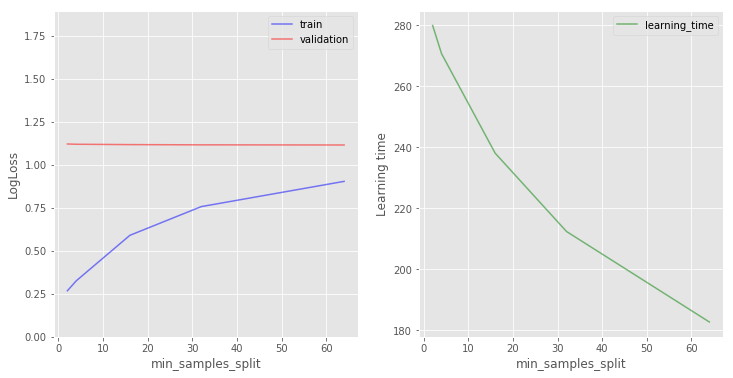

In [101]:
Plotter().plot_curve(split_curve)

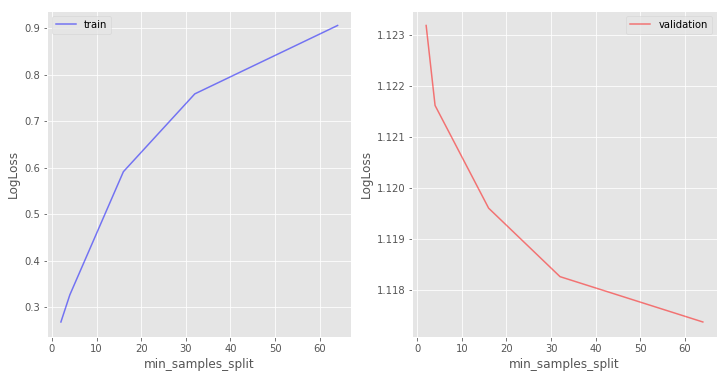

In [100]:
Plotter().plot_curve(split_curve, separately=True, learning_time=False, ylim=None)

The graphs show that higher values of min_samples_split both help fighting overfitting on the train set and improving test set metric, along with decreasing learning time. Using the best found value.

In [103]:
split_curve.get_best_point()

{'value': 64,
 'test_metric': 1.1173659115520571,
 'train_metric': 0.9054375874681062,
 'learning_time': 182.7831396006665}

#### 10.6 Parameter 'min_samples_leaf'

In [105]:
unaltered_params = {"random_state": 17, 'n_estimators': 350, 'max_features':150, 'min_samples_split' : 64 }
leaf_curve = LearningCurve('min_samples_leaf', unaltered_params, X, y)

for samples_leaf in [1, 2, 4, 16, 32, 64, 128]:
    point = leaf_curve.add_learning_point(samples_leaf)

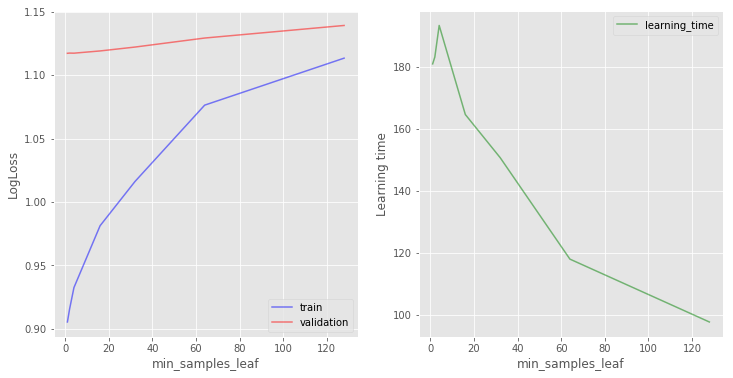

In [108]:
Plotter().plot_curve(leaf_curve, ylim=None)

In [109]:
leaf_curve.get_curve_points()

[{'value': 1,
  'test_metric': 1.1173659115520571,
  'mean_train_metric': 0.9054375874681062,
  'learning_time': 180.9890582763334},
 {'value': 2,
  'test_metric': 1.1175299641825192,
  'mean_train_metric': 0.9156516670290062,
  'learning_time': 183.1895541919997},
 {'value': 4,
  'test_metric': 1.1174568706696426,
  'mean_train_metric': 0.9325664969627331,
  'learning_time': 193.38234365866688},
 {'value': 16,
  'test_metric': 1.1192183281028385,
  'mean_train_metric': 0.9813513859133055,
  'learning_time': 164.6497659080002},
 {'value': 32,
  'test_metric': 1.122277131361894,
  'mean_train_metric': 1.0162120230667215,
  'learning_time': 150.72809650233344},
 {'value': 64,
  'test_metric': 1.1293972875642737,
  'mean_train_metric': 1.076466166424139,
  'learning_time': 118.00254275800035},
 {'value': 128,
  'test_metric': 1.1393144688440706,
  'mean_train_metric': 1.1135325160304756,
  'learning_time': 97.7225826799998}]

Increasing the min_samples_leaf leads to overfitting not only on train set, but on the validation as well. Not changing the default value "1" of this parameter.

### Part 11. Prediction for test or hold-out samples<a id='part11'></a>

In [81]:
y_train = train_df['CareerSatisfaction']
X_train = train_df.drop(columns=['CareerSatisfaction'])

Load hold-out set from the disk

In [69]:
test_df = pd.read_csv('test.csv', index_col='Respondent')

In [70]:
y_test = test_df['CareerSatisfaction']
X_test = test_df.drop(columns=['CareerSatisfaction'])

In [71]:
random_forest = RandomForestClassifier(
    random_state=17, n_estimators=350, max_features=150, min_samples_split=64)

Forming duplicate train set with samples balanced among classes (with simple bootstrapping, as earlier).

In [72]:
train_balanced_df = balance_dataset(train_df)

y_train_balanced = train_balanced_df['CareerSatisfaction']
X_train_balanced = train_balanced_df.drop(columns=['CareerSatisfaction'])

Fitting estimators on the whole train sets, evaluating on hold-out set.

In [73]:
random_forest_balanced = RandomForestClassifier(
    random_state=17, n_estimators=350, max_features=150, min_samples_split=64)

LogLoss value:  1.1169307446742236


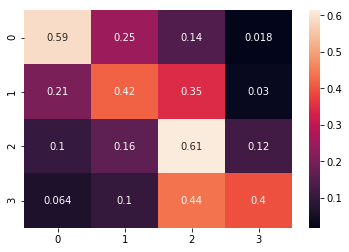

In [74]:
evaluate_predictions(random_forest, X_train, y_train, X_test, y_test)

LogLoss value:  1.1491224359465828


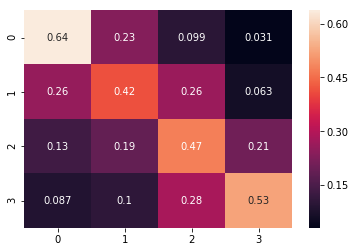

In [76]:
evaluate_predictions(random_forest_balanced, X_train_balanced, y_train_balanced, X_test, y_test)

This way, the value of the metric on the hold-out set is close to those seen during cross-validation. The first is even slightly better (1.1169307446742236 vs. 1.1173659115520571), but there's no reason to suspect biased or leaked hold-out set creation. The samples were just randomly selected from the common set, saved to disk, loaded temporarily  only to complement with features proven on the train set, and did not participated in hyperparameter tuning. It looks like such small improvement can be explained by a lucky coincidence. <br/>
Again, straight method of class balancing decreases logloss metric value, but the confusion matrixes (both, actually) looks much better than those in [8.3 Confusion matrix](#confusion_matrix) part with initial 7 classes. 

### Part 12. Conclusion<a id='part12'></a>

For the conclusion let's first see what features are considered as the most important by the RandomForest model. The factors that can influence developer's career satisfaction looks like the most interesting part of such research.<br>
(The transcript of corresponding questions can be found in the [beggining of this notebook](#survey_questions))

In [125]:
most_important_indx = np.argsort(-random_forest.feature_importances_)[:100]
X_train.columns[most_important_indx]

Index(['JobSatisfaction', 'ConvertedSalary', 'JobSearchStatus_1', 'Salary',
       'AgreeDisagree1', 'YearsCodingProf', 'YearsCoding', 'AgreeDisagree3',
       'CompanySize', 'LastNewJob', 'JobSearchStatus_2', 'AssessJob8',
       'WakeTime', 'AssessJob10', 'AssessBenefits6', 'AssessBenefits11',
       'AssessJob4', 'AssessBenefits10', 'AssessBenefits3', 'AssessJob5',
       'AssessJob6', 'AssessJob3', 'AssessBenefits2', 'AssessJob7',
       'AssessJob2', 'AssessBenefits5', 'AssessBenefits8', 'AssessBenefits7',
       'AssessJob1', 'AssessBenefits4', 'JobContactPriorities5',
       'JobContactPriorities4', 'TimeFullyProductive', 'AssessBenefits9',
       'JobContactPriorities1', 'JobContactPriorities3', 'Age',
       'AssessBenefits1', 'AssessJob9', 'AdsPriorities1', 'HypotheticalTools4',
       'HypotheticalTools2', 'AgreeDisagree2', 'AdsPriorities3',
       'JobContactPriorities2', 'HypotheticalTools3', 'AdsPriorities2',
       'AdsPriorities5', 'AdsPriorities4', 'AdsAgreeDisagree2',

<p>Again, the most significant feature is current job satisfaction. The overall career satisfaction is also affected by salary, coding experience, relationships with peers and involvement into community, job search status, attitude to benefits, attitude to job characteristics, (suddenly!) attitude to ads, current company conditions, lifestyle, hopes, education, dev roles, country and ethnicity, etc.</p>

<p>The 1.116 is not so high value for logloss metric, but the dataset is quite raw, and it turned out to be a challenging task to distinguish developer's career satisfaction level from the "default" answer "Moderately satisfied". Anyway, the improvement over baselines was achieved. The model looks like allowing further enhancement by hyperparameters tuning, but it requires high computational power and more time. There are over 700 columns in the dataset now; possibly this number can be reduced during further solution improvement, using, for example, feature importances denoted by the developed model.</p>
<p>However, the greatest benefit would be brought by gathering more answers from respondents giving grade other than "Moderately satisfied", especially those with "dissatisfied" levels. (And it is also a valuable task to find out what makes people unhappy). As it can be seen above, even simple duplication/bootstraping of the data from minority classes, or uniting them together, helps to reduce their confusion with higher levels of satisfaction.</p>

<p>Possibly, another interesting research can be devoted to predicting <b>JobSatisfaction</b> level by other factors. Maybe they would correlate with it more directly than with overall career satisfaction. And the CareerSatisfaction value is hard to predict without JobSatisfaction feature at this moment. </p>
<p>Nevertheless, both tasks can provide helpful information and insights for managers and HRs as well as for the developer community itself.</p>